## Import Packages

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import collections
import pickle
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import csv
from sklearn.model_selection import train_test_split
import time
from scipy.ndimage.measurements import label
from random import shuffle

%matplotlib inline
np.set_printoptions(threshold=np.nan)


## Load Images

#### GTI Vehicle Image Database, KITTI vision benchmark suite, Examples from Project Video


In [21]:
car_images = glob.glob('vehicles/*/*.png')
not_car_images = glob.glob('non-vehicles/*/*.png')
#white_images = glob.glob('white/vehicle/*.jpg')
#non_white_images = glob.glob('white/non-vehicle/*.jpg')
print(len(car_images),len(not_car_images))

8792 8968


#### Udacity dataset

In [3]:
samples = []
with open('./object-dataset/labels1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
shuffle(samples)
print(len(samples))

60788


## Histogram of Oriented Gradients 

In [1]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
    return features

## Compressed Spatial Vector

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1,color2,color3))

## Colour Histograms

In [39]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Read Image Loop

In [7]:
def dataset_one_loop(imgs,cspace,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,hist_range):
    # Iterate through the list of images
    features = []
    #i=0
    for file in imgs:
        #i=0
        # Read in each one by one
        image = cv2.imread(file)
        single_feature = extract_features(image,cspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
        features.append(single_feature)
        #i+=1
        #if i ==50:
         #   break
    return np.array(features)

In [8]:
def dataset_two_loop(samples,cspace,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins, hist_range):
    # Iterate through the list of images
    features = []
    i=0
    for sample in samples:
        car = cv2.imread('./object-dataset/'+str(sample[0]))
        img_tosearch = car[int(sample[2]):int(sample[4]),int(sample[1]):int(sample[3]),:]
        image = cv2.resize(img_tosearch, (64,64))
        single_feature = extract_features(image,cspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
        features.append(single_feature)
        i+=1
        if i ==8000:
            break
    return np.array(features)

## Feature Extraction

In [4]:
def extract_features(image,cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32,32), hist_bins=32, hist_range=(0, 256)):
    combined_features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LAB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    combined_features.append(spatial_features)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins)
    combined_features.append(hist_features)
    # Append the new feature vector to the features list
    combined_features.append(hog_features)
    #i += 1
        #if i == 5000:
        #    break
    # Return list of feature vectors
    return np.concatenate(combined_features)


## Declare Car/Non-Car Features 

In [10]:
car_features = dataset_one_loop(car_images, cspace='YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256))
notcar_features = dataset_one_loop(not_car_images, cspace='YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256))
car_uda_features = dataset_two_loop(samples, cspace='YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(16, 16), hist_bins=16, hist_range=(0, 256))
#whitecar_features = dataset_one_loop(white_images, cspace='HLS', orient = 11, pix_per_cell = 16, cell_per_block = 2,hog_channel='ALL',spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
#nonwhitecar_features = dataset_one_loop(non_white_images, cspace='HLS', orient = 11, pix_per_cell = 16, cell_per_block = 2,hog_channel='ALL',spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Combine and Normalize Feature Vectors and Labels

(25760, 6108)


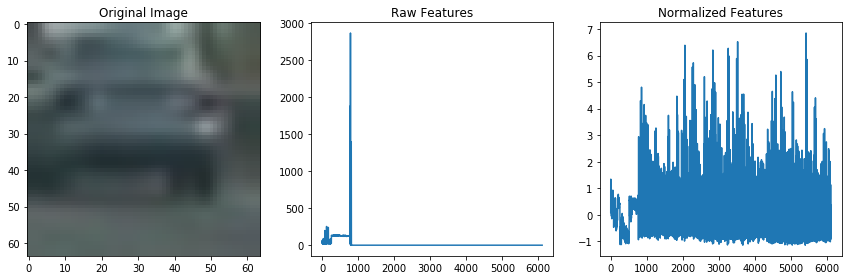

In [11]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    
    X = np.vstack((car_features, notcar_features, car_uda_features)).astype(np.float64)                        
    # Fit a per-column scaler
    print(X.shape)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, 50)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[20000])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    pickle.dump(X_scaler, open("x_scaler.p","wb"))
    
else: 
    print('Your function only returns empty feature vectors...')

#Define labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)),np.ones(len(car_uda_features))))

## Split and Randomize 

In [12]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Training the Classifier

In [13]:
#print('Using:',orient,'orientations',pix_per_cell,
#    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 500
a = svc.decision_function(X_test[0:n_predict])
#print('My SVC predicts: ', a)
b = y_test[0:n_predict]
#print('For these',n_predict, 'labels: ', b)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
c = np.where(b == 1)
d = np.take(a,c)
print('Lowest decision function value for car label: ', d.min())

Feature vector length: 6108
27.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9792
0.00651 Seconds to predict 500 labels with SVC
Lowest decision function value for car label:  -2.6915608108


## Save Model

In [14]:
filename = 'model_8.sav'
pickle.dump(svc, open(filename, 'wb'))

## Convert Colourspace

In [19]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'YCrCb2RGB':
        return cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)


## Perform Sub-Sampled Window Search and Draw Bounding Boxes

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.asarray(img)
    img_tosearch = draw_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    #ctrans_tosearch = img_tosearch
    bbox_list=[]
    
    for scale in np.arange(1.0,2.8,0.2):
        if scale != 1:
            imshape = img_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) + 1 # i.e. 2x2 blocks = 19 blocks
        nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
        nfeat_per_block = orient*cell_per_block**2 #squared for 2 dimensions: x and y

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1 # 7 blocks per window
        cells_per_step_x = 2
        cells_per_step_y = 2 # Instead of overlap, define how many cells to step 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x #steps taken by window
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):

                ypos = yb*cells_per_step_y
                xpos = xb*cells_per_step_x
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
                test_prediction = load_model.decision_function(test_features)
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    


                if test_prediction >= 2.0:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

## Plot Heat Map

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

## Apply Threshold on Heat Map

In [8]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## Draw Labeled Boxes

In [9]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    drawn_img = np.copy(img)
    #bbox_final = ((0,0),(0,0))
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzerogrid = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzerogrid[0])
        nonzerox = np.array(nonzerogrid[1])
        # Define a bounding box based on min/max x and y
        bbox_final = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(drawn_img, bbox_final[0], bbox_final[1], (0,0,255), 6)
    # Return the image

    return drawn_img

## Video Pipeline Parameters

In [28]:
ystart = 400
ystop = 656
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=(16,16)
hist_bins=16
hist_range=(0, 256)

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Heatmap Pipeline

In [12]:
def heatmap_search(img , hot_windows, frames, threshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img, heatmap

## Convert Bounding Box 3D Tensor to Single 3D Vector

In [13]:
def Gather(self):
    bounds = np.asarray(self.boundbox)
    frames = bounds.shape[0]
    bounding = np.vstack(bounds)
    return bounding, frames

## Average Heatmap Values

In [14]:
def Average(self):
    maps = np.asarray(self.heatmap)
    if len(maps)>0:
        avg=0
        for map in maps:
            avg +=map
        avg = avg / len(maps)
    else:
        avg = np.zeros_like(self[:,:,0]).astype(np.float)
    return avg

## Image Processing Pipeline

In [24]:
def Process_Image(file):
    image_find = np.copy(file)
    image_heat = np.copy(file)
    image_final = np.copy(file)
    out_img, bbox = find_cars(image_find, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    
    bboxes, nframes = Gather(heat_map)
    thresh = 1+(nframes//2.0)
    print(nframes,thresh)
    final,hmap = heatmap_search(image_heat, bboxes, nframes, threshold =thresh)
#    heat_map.heatmap.append(hmap)
#    avg_map = Average(heat_map)
#    final_avg = apply_threshold(avg_map, 13)
#    heatmap_final = np.clip(final_avg, 0, 255)
#    labels_final = label(heatmap_final)
#    draw_img_final = draw_labeled_bboxes(image_final, labels_final)
    
    return final

## Bounding Box Classes

In [25]:
class Heat():
    def __init__(self, n=10):
        # number of previous frames to save heat map data from
        self.n = n
        # number of maps in buffer
        self.n_buffered = 0
        # was the map detected in the last iteration?
        self.first = False  
        # x values of the last n fits of the line
        self.heatmap = collections.deque([], maxlen=n)
        # y values of the last n fits of the line
        self.boundbox = collections.deque([], maxlen=12)

## Load Model

In [17]:
filename = 'model_8.sav'
load_model = pickle.load(open(filename, 'rb'))
X_scaler = pickle.load(open('x_scaler.p', 'rb'))

# Make Video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def Video():
    white_output = 'test_videos_output/project_video_3.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(Process_Image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

In [23]:
heat_map = Heat()
Video()

1 1.0
[MoviePy] >>>> Building video test_videos_output/project_video_3.mp4
[MoviePy] Writing video test_videos_output/project_video_3.mp4


  0%|                                                                       | 0/1261 [00:00<?, ?it/s]

2 2.0


  0%|                                                             | 1/1261 [00:03<1:10:16,  3.35s/it]

3 2.0


  0%|                                                             | 2/1261 [00:06<1:11:23,  3.40s/it]

4 3.0


  0%|▏                                                            | 3/1261 [00:10<1:11:19,  3.40s/it]

5 3.0


  0%|▏                                                            | 4/1261 [00:13<1:12:31,  3.46s/it]

6 4.0


  0%|▏                                                            | 5/1261 [00:17<1:12:40,  3.47s/it]

7 4.0


  0%|▎                                                            | 6/1261 [00:20<1:12:13,  3.45s/it]

8 5.0


  1%|▎                                                            | 7/1261 [00:24<1:12:22,  3.46s/it]

9 5.0


  1%|▍                                                            | 8/1261 [00:27<1:12:00,  3.45s/it]

10 6.0


  1%|▍                                                            | 9/1261 [00:31<1:11:43,  3.44s/it]

11 6.0


  1%|▍                                                           | 10/1261 [00:34<1:11:14,  3.42s/it]

12 7.0


  1%|▌                                                           | 11/1261 [00:37<1:10:45,  3.40s/it]

12 7.0


  1%|▌                                                           | 12/1261 [00:41<1:10:37,  3.39s/it]

12 7.0


  1%|▌                                                           | 13/1261 [00:44<1:10:42,  3.40s/it]

12 7.0


  1%|▋                                                           | 14/1261 [00:48<1:10:58,  3.41s/it]

12 7.0


  1%|▋                                                           | 15/1261 [00:51<1:10:41,  3.40s/it]

12 7.0


  1%|▊                                                           | 16/1261 [00:54<1:10:55,  3.42s/it]

12 7.0


  1%|▊                                                           | 17/1261 [00:58<1:10:25,  3.40s/it]

12 7.0


  1%|▊                                                           | 18/1261 [01:01<1:10:07,  3.38s/it]

12 7.0


  2%|▉                                                           | 19/1261 [01:04<1:09:44,  3.37s/it]

12 7.0


  2%|▉                                                           | 20/1261 [01:08<1:09:47,  3.37s/it]

12 7.0


  2%|▉                                                           | 21/1261 [01:11<1:09:48,  3.38s/it]

12 7.0


  2%|█                                                           | 22/1261 [01:15<1:09:52,  3.38s/it]

12 7.0


  2%|█                                                           | 23/1261 [01:18<1:09:28,  3.37s/it]

12 7.0


  2%|█▏                                                          | 24/1261 [01:21<1:09:34,  3.37s/it]

12 7.0


  2%|█▏                                                          | 25/1261 [01:25<1:09:16,  3.36s/it]

12 7.0


  2%|█▏                                                          | 26/1261 [01:28<1:09:04,  3.36s/it]

12 7.0


  2%|█▎                                                          | 27/1261 [01:31<1:08:57,  3.35s/it]

12 7.0


  2%|█▎                                                          | 28/1261 [01:35<1:08:59,  3.36s/it]

12 7.0


  2%|█▍                                                          | 29/1261 [01:38<1:08:43,  3.35s/it]

12 7.0


  2%|█▍                                                          | 30/1261 [01:41<1:08:50,  3.36s/it]

12 7.0


  2%|█▍                                                          | 31/1261 [01:45<1:08:44,  3.35s/it]

12 7.0


  3%|█▌                                                          | 32/1261 [01:48<1:08:38,  3.35s/it]

12 7.0


  3%|█▌                                                          | 33/1261 [01:51<1:08:27,  3.34s/it]

12 7.0


  3%|█▌                                                          | 34/1261 [01:55<1:07:51,  3.32s/it]

12 7.0


  3%|█▋                                                          | 35/1261 [01:58<1:08:08,  3.33s/it]

12 7.0


  3%|█▋                                                          | 36/1261 [02:01<1:08:32,  3.36s/it]

12 7.0


  3%|█▊                                                          | 37/1261 [02:05<1:08:30,  3.36s/it]

12 7.0


  3%|█▊                                                          | 38/1261 [02:08<1:08:19,  3.35s/it]

12 7.0


  3%|█▊                                                          | 39/1261 [02:11<1:08:07,  3.34s/it]

12 7.0


  3%|█▉                                                          | 40/1261 [02:15<1:07:56,  3.34s/it]

12 7.0


  3%|█▉                                                          | 41/1261 [02:18<1:08:05,  3.35s/it]

12 7.0


  3%|█▉                                                          | 42/1261 [02:22<1:08:14,  3.36s/it]

12 7.0


  3%|██                                                          | 43/1261 [02:25<1:08:35,  3.38s/it]

12 7.0


  3%|██                                                          | 44/1261 [02:28<1:08:00,  3.35s/it]

12 7.0


  4%|██▏                                                         | 45/1261 [02:32<1:07:46,  3.34s/it]

12 7.0


  4%|██▏                                                         | 46/1261 [02:35<1:07:44,  3.35s/it]

12 7.0


  4%|██▏                                                         | 47/1261 [02:38<1:07:44,  3.35s/it]

12 7.0


  4%|██▎                                                         | 48/1261 [02:42<1:07:40,  3.35s/it]

12 7.0


  4%|██▎                                                         | 49/1261 [02:45<1:08:15,  3.38s/it]

12 7.0


  4%|██▍                                                         | 50/1261 [02:48<1:08:05,  3.37s/it]

12 7.0


  4%|██▍                                                         | 51/1261 [02:52<1:08:02,  3.37s/it]

12 7.0


  4%|██▍                                                         | 52/1261 [02:55<1:08:16,  3.39s/it]

12 7.0


  4%|██▌                                                         | 53/1261 [02:59<1:07:54,  3.37s/it]

12 7.0


  4%|██▌                                                         | 54/1261 [03:02<1:07:59,  3.38s/it]

12 7.0


  4%|██▌                                                         | 55/1261 [03:05<1:07:36,  3.36s/it]

12 7.0


  4%|██▋                                                         | 56/1261 [03:09<1:07:08,  3.34s/it]

12 7.0


  5%|██▋                                                         | 57/1261 [03:12<1:06:56,  3.34s/it]

12 7.0


  5%|██▊                                                         | 58/1261 [03:15<1:07:42,  3.38s/it]

12 7.0


  5%|██▊                                                         | 59/1261 [03:19<1:08:56,  3.44s/it]

12 7.0


  5%|██▊                                                         | 60/1261 [03:23<1:09:26,  3.47s/it]

12 7.0


  5%|██▉                                                         | 61/1261 [03:26<1:08:30,  3.43s/it]

12 7.0


  5%|██▉                                                         | 62/1261 [03:29<1:08:24,  3.42s/it]

12 7.0


  5%|██▉                                                         | 63/1261 [03:33<1:07:50,  3.40s/it]

12 7.0


  5%|███                                                         | 64/1261 [03:36<1:07:27,  3.38s/it]

12 7.0


  5%|███                                                         | 65/1261 [03:39<1:07:19,  3.38s/it]

12 7.0


  5%|███▏                                                        | 66/1261 [03:43<1:07:21,  3.38s/it]

12 7.0


  5%|███▏                                                        | 67/1261 [03:46<1:07:01,  3.37s/it]

12 7.0


  5%|███▏                                                        | 68/1261 [03:49<1:07:02,  3.37s/it]

12 7.0


  5%|███▎                                                        | 69/1261 [03:53<1:07:11,  3.38s/it]

12 7.0


  6%|███▎                                                        | 70/1261 [03:56<1:06:36,  3.36s/it]

12 7.0


  6%|███▍                                                        | 71/1261 [04:00<1:06:36,  3.36s/it]

12 7.0


  6%|███▍                                                        | 72/1261 [04:03<1:06:35,  3.36s/it]

12 7.0


  6%|███▍                                                        | 73/1261 [04:06<1:06:37,  3.36s/it]

12 7.0


  6%|███▌                                                        | 74/1261 [04:10<1:06:57,  3.38s/it]

12 7.0


  6%|███▌                                                        | 75/1261 [04:13<1:06:56,  3.39s/it]

12 7.0


  6%|███▌                                                        | 76/1261 [04:16<1:06:51,  3.38s/it]

12 7.0


  6%|███▋                                                        | 77/1261 [04:20<1:06:53,  3.39s/it]

12 7.0


  6%|███▋                                                        | 78/1261 [04:23<1:06:57,  3.40s/it]

12 7.0


  6%|███▊                                                        | 79/1261 [04:27<1:06:14,  3.36s/it]

12 7.0


  6%|███▊                                                        | 80/1261 [04:30<1:06:18,  3.37s/it]

12 7.0


  6%|███▊                                                        | 81/1261 [04:33<1:06:19,  3.37s/it]

12 7.0


  7%|███▉                                                        | 82/1261 [04:37<1:06:00,  3.36s/it]

12 7.0


  7%|███▉                                                        | 83/1261 [04:40<1:06:10,  3.37s/it]

12 7.0


  7%|███▉                                                        | 84/1261 [04:43<1:06:09,  3.37s/it]

12 7.0


  7%|████                                                        | 85/1261 [04:47<1:06:38,  3.40s/it]

12 7.0


  7%|████                                                        | 86/1261 [04:50<1:06:27,  3.39s/it]

12 7.0


  7%|████▏                                                       | 87/1261 [04:54<1:06:17,  3.39s/it]

12 7.0


  7%|████▏                                                       | 88/1261 [04:57<1:06:16,  3.39s/it]

12 7.0


  7%|████▏                                                       | 89/1261 [05:00<1:06:20,  3.40s/it]

12 7.0


  7%|████▎                                                       | 90/1261 [05:04<1:06:08,  3.39s/it]

12 7.0


  7%|████▎                                                       | 91/1261 [05:07<1:05:38,  3.37s/it]

12 7.0


  7%|████▍                                                       | 92/1261 [05:10<1:05:09,  3.34s/it]

12 7.0


  7%|████▍                                                       | 93/1261 [05:14<1:05:16,  3.35s/it]

12 7.0


  7%|████▍                                                       | 94/1261 [05:17<1:05:29,  3.37s/it]

12 7.0


  8%|████▌                                                       | 95/1261 [05:21<1:05:16,  3.36s/it]

12 7.0


  8%|████▌                                                       | 96/1261 [05:24<1:05:32,  3.38s/it]

12 7.0


  8%|████▌                                                       | 97/1261 [05:27<1:05:14,  3.36s/it]

12 7.0


  8%|████▋                                                       | 98/1261 [05:31<1:05:04,  3.36s/it]

12 7.0


  8%|████▋                                                       | 99/1261 [05:34<1:05:08,  3.36s/it]

12 7.0


  8%|████▋                                                      | 100/1261 [05:37<1:04:58,  3.36s/it]

12 7.0


  8%|████▋                                                      | 101/1261 [05:41<1:04:56,  3.36s/it]

12 7.0


  8%|████▊                                                      | 102/1261 [05:44<1:04:56,  3.36s/it]

12 7.0


  8%|████▊                                                      | 103/1261 [05:47<1:05:10,  3.38s/it]

12 7.0


  8%|████▊                                                      | 104/1261 [05:51<1:05:04,  3.37s/it]

12 7.0


  8%|████▉                                                      | 105/1261 [05:54<1:05:29,  3.40s/it]

12 7.0


  8%|████▉                                                      | 106/1261 [05:58<1:05:28,  3.40s/it]

12 7.0


  8%|█████                                                      | 107/1261 [06:01<1:05:45,  3.42s/it]

12 7.0


  9%|█████                                                      | 108/1261 [06:05<1:05:08,  3.39s/it]

12 7.0


  9%|█████                                                      | 109/1261 [06:08<1:04:31,  3.36s/it]

12 7.0


  9%|█████▏                                                     | 110/1261 [06:11<1:04:20,  3.35s/it]

12 7.0


  9%|█████▏                                                     | 111/1261 [06:14<1:04:17,  3.35s/it]

12 7.0


  9%|█████▏                                                     | 112/1261 [06:18<1:04:03,  3.34s/it]

12 7.0


  9%|█████▎                                                     | 113/1261 [06:21<1:04:25,  3.37s/it]

12 7.0


  9%|█████▎                                                     | 114/1261 [06:25<1:04:27,  3.37s/it]

12 7.0


  9%|█████▍                                                     | 115/1261 [06:28<1:04:28,  3.38s/it]

12 7.0


  9%|█████▍                                                     | 116/1261 [06:31<1:04:11,  3.36s/it]

12 7.0


  9%|█████▍                                                     | 117/1261 [06:35<1:03:58,  3.35s/it]

12 7.0


  9%|█████▌                                                     | 118/1261 [06:38<1:04:05,  3.36s/it]

12 7.0


  9%|█████▌                                                     | 119/1261 [06:41<1:04:19,  3.38s/it]

12 7.0


 10%|█████▌                                                     | 120/1261 [06:45<1:04:23,  3.39s/it]

12 7.0


 10%|█████▋                                                     | 121/1261 [06:48<1:03:54,  3.36s/it]

12 7.0


 10%|█████▋                                                     | 122/1261 [06:52<1:03:52,  3.36s/it]

12 7.0


 10%|█████▊                                                     | 123/1261 [06:55<1:03:36,  3.35s/it]

12 7.0


 10%|█████▊                                                     | 124/1261 [06:58<1:03:21,  3.34s/it]

12 7.0


 10%|█████▊                                                     | 125/1261 [07:02<1:03:21,  3.35s/it]

12 7.0


 10%|█████▉                                                     | 126/1261 [07:05<1:03:22,  3.35s/it]

12 7.0


 10%|█████▉                                                     | 127/1261 [07:08<1:03:10,  3.34s/it]

12 7.0


 10%|█████▉                                                     | 128/1261 [07:12<1:03:14,  3.35s/it]

12 7.0


 10%|██████                                                     | 129/1261 [07:15<1:03:29,  3.37s/it]

12 7.0


 10%|██████                                                     | 130/1261 [07:18<1:03:30,  3.37s/it]

12 7.0


 10%|██████▏                                                    | 131/1261 [07:22<1:04:14,  3.41s/it]

12 7.0


 10%|██████▏                                                    | 132/1261 [07:25<1:04:32,  3.43s/it]

12 7.0


 11%|██████▏                                                    | 133/1261 [07:29<1:03:59,  3.40s/it]

12 7.0


 11%|██████▎                                                    | 134/1261 [07:32<1:03:33,  3.38s/it]

12 7.0


 11%|██████▎                                                    | 135/1261 [07:35<1:03:07,  3.36s/it]

12 7.0


 11%|██████▎                                                    | 136/1261 [07:39<1:03:24,  3.38s/it]

12 7.0


 11%|██████▍                                                    | 137/1261 [07:42<1:02:48,  3.35s/it]

12 7.0


 11%|██████▍                                                    | 138/1261 [07:45<1:02:32,  3.34s/it]

12 7.0


 11%|██████▌                                                    | 139/1261 [07:49<1:02:24,  3.34s/it]

12 7.0


 11%|██████▌                                                    | 140/1261 [07:52<1:02:20,  3.34s/it]

12 7.0


 11%|██████▌                                                    | 141/1261 [07:55<1:02:45,  3.36s/it]

12 7.0


 11%|██████▋                                                    | 142/1261 [07:59<1:02:35,  3.36s/it]

12 7.0


 11%|██████▋                                                    | 143/1261 [08:02<1:02:37,  3.36s/it]

12 7.0


 11%|██████▋                                                    | 144/1261 [08:06<1:02:42,  3.37s/it]

12 7.0


 11%|██████▊                                                    | 145/1261 [08:09<1:02:16,  3.35s/it]

12 7.0


 12%|██████▊                                                    | 146/1261 [08:12<1:02:00,  3.34s/it]

12 7.0


 12%|██████▉                                                    | 147/1261 [08:16<1:02:22,  3.36s/it]

12 7.0


 12%|██████▉                                                    | 148/1261 [08:19<1:02:16,  3.36s/it]

12 7.0


 12%|██████▉                                                    | 149/1261 [08:22<1:02:10,  3.35s/it]

12 7.0


 12%|███████                                                    | 150/1261 [08:26<1:02:24,  3.37s/it]

12 7.0


 12%|███████                                                    | 151/1261 [08:29<1:02:28,  3.38s/it]

12 7.0


 12%|███████                                                    | 152/1261 [08:32<1:02:27,  3.38s/it]

12 7.0


 12%|███████▏                                                   | 153/1261 [08:36<1:02:30,  3.39s/it]

12 7.0


 12%|███████▏                                                   | 154/1261 [08:39<1:02:12,  3.37s/it]

12 7.0


 12%|███████▎                                                   | 155/1261 [08:43<1:02:08,  3.37s/it]

12 7.0


 12%|███████▎                                                   | 156/1261 [08:46<1:02:39,  3.40s/it]

12 7.0


 12%|███████▎                                                   | 157/1261 [08:49<1:02:29,  3.40s/it]

12 7.0


 13%|███████▍                                                   | 158/1261 [08:53<1:02:20,  3.39s/it]

12 7.0


 13%|███████▍                                                   | 159/1261 [08:56<1:02:07,  3.38s/it]

12 7.0


 13%|███████▍                                                   | 160/1261 [09:00<1:02:08,  3.39s/it]

12 7.0


 13%|███████▌                                                   | 161/1261 [09:03<1:02:11,  3.39s/it]

12 7.0


 13%|███████▌                                                   | 162/1261 [09:06<1:02:12,  3.40s/it]

12 7.0


 13%|███████▋                                                   | 163/1261 [09:10<1:02:23,  3.41s/it]

12 7.0


 13%|███████▋                                                   | 164/1261 [09:13<1:02:17,  3.41s/it]

12 7.0


 13%|███████▋                                                   | 165/1261 [09:17<1:01:47,  3.38s/it]

12 7.0


 13%|███████▊                                                   | 166/1261 [09:20<1:01:45,  3.38s/it]

12 7.0


 13%|███████▊                                                   | 167/1261 [09:23<1:01:45,  3.39s/it]

12 7.0


 13%|███████▊                                                   | 168/1261 [09:27<1:01:27,  3.37s/it]

12 7.0


 13%|███████▉                                                   | 169/1261 [09:30<1:01:19,  3.37s/it]

12 7.0


 13%|███████▉                                                   | 170/1261 [09:33<1:01:07,  3.36s/it]

12 7.0


 14%|████████                                                   | 171/1261 [09:37<1:00:51,  3.35s/it]

12 7.0


 14%|████████                                                   | 172/1261 [09:40<1:00:43,  3.35s/it]

12 7.0


 14%|████████                                                   | 173/1261 [09:43<1:00:45,  3.35s/it]

12 7.0


 14%|████████▏                                                  | 174/1261 [09:47<1:01:03,  3.37s/it]

12 7.0


 14%|████████▏                                                  | 175/1261 [09:50<1:01:28,  3.40s/it]

12 7.0


 14%|████████▏                                                  | 176/1261 [09:54<1:01:10,  3.38s/it]

12 7.0


 14%|████████▎                                                  | 177/1261 [09:57<1:01:03,  3.38s/it]

12 7.0


 14%|████████▎                                                  | 178/1261 [10:00<1:00:59,  3.38s/it]

12 7.0


 14%|████████▍                                                  | 179/1261 [10:04<1:00:51,  3.37s/it]

12 7.0


 14%|████████▍                                                  | 180/1261 [10:07<1:00:48,  3.38s/it]

12 7.0


 14%|████████▍                                                  | 181/1261 [10:10<1:00:31,  3.36s/it]

12 7.0


 14%|████████▌                                                  | 182/1261 [10:14<1:00:22,  3.36s/it]

12 7.0


 15%|████████▌                                                  | 183/1261 [10:17<1:00:41,  3.38s/it]

12 7.0


 15%|████████▌                                                  | 184/1261 [10:21<1:00:30,  3.37s/it]

12 7.0


 15%|████████▋                                                  | 185/1261 [10:24<1:00:37,  3.38s/it]

12 7.0


 15%|████████▋                                                  | 186/1261 [10:27<1:00:57,  3.40s/it]

12 7.0


 15%|████████▋                                                  | 187/1261 [10:31<1:00:57,  3.41s/it]

12 7.0


 15%|████████▊                                                  | 188/1261 [10:34<1:01:05,  3.42s/it]

12 7.0


 15%|████████▊                                                  | 189/1261 [10:38<1:00:57,  3.41s/it]

12 7.0


 15%|████████▉                                                  | 190/1261 [10:41<1:01:05,  3.42s/it]

12 7.0


 15%|████████▉                                                  | 191/1261 [10:45<1:01:23,  3.44s/it]

12 7.0


 15%|████████▉                                                  | 192/1261 [10:48<1:01:17,  3.44s/it]

12 7.0


 15%|█████████                                                  | 193/1261 [10:52<1:01:23,  3.45s/it]

12 7.0


 15%|█████████                                                  | 194/1261 [10:55<1:01:12,  3.44s/it]

12 7.0


 15%|█████████                                                  | 195/1261 [10:58<1:00:33,  3.41s/it]

12 7.0


 16%|█████████▏                                                 | 196/1261 [11:02<1:00:27,  3.41s/it]

12 7.0


 16%|█████████▏                                                 | 197/1261 [11:05<1:00:23,  3.41s/it]

12 7.0


 16%|█████████▎                                                 | 198/1261 [11:08<1:00:16,  3.40s/it]

12 7.0


 16%|█████████▎                                                 | 199/1261 [11:12<1:00:22,  3.41s/it]

12 7.0


 16%|█████████▎                                                 | 200/1261 [11:15<1:00:28,  3.42s/it]

12 7.0


 16%|█████████▍                                                 | 201/1261 [11:19<1:00:25,  3.42s/it]

12 7.0


 16%|█████████▍                                                 | 202/1261 [11:22<1:00:07,  3.41s/it]

12 7.0


 16%|█████████▊                                                   | 203/1261 [11:26<59:53,  3.40s/it]

12 7.0


 16%|█████████▊                                                   | 204/1261 [11:29<59:53,  3.40s/it]

12 7.0


 16%|█████████▉                                                   | 205/1261 [11:32<59:52,  3.40s/it]

12 7.0


 16%|█████████▉                                                   | 206/1261 [11:36<59:57,  3.41s/it]

12 7.0


 16%|█████████▋                                                 | 207/1261 [11:39<1:00:38,  3.45s/it]

12 7.0


 16%|█████████▋                                                 | 208/1261 [11:43<1:00:20,  3.44s/it]

12 7.0


 17%|██████████                                                   | 209/1261 [11:46<59:52,  3.41s/it]

12 7.0


 17%|██████████▏                                                  | 210/1261 [11:49<59:32,  3.40s/it]

12 7.0


 17%|██████████▏                                                  | 211/1261 [11:53<59:37,  3.41s/it]

12 7.0


 17%|██████████▎                                                  | 212/1261 [11:56<59:18,  3.39s/it]

12 7.0


 17%|██████████▎                                                  | 213/1261 [12:00<58:49,  3.37s/it]

12 7.0


 17%|██████████▎                                                  | 214/1261 [12:03<58:57,  3.38s/it]

12 7.0


 17%|██████████▍                                                  | 215/1261 [12:06<59:08,  3.39s/it]

12 7.0


 17%|██████████▍                                                  | 216/1261 [12:10<59:11,  3.40s/it]

12 7.0


 17%|██████████▍                                                  | 217/1261 [12:13<59:21,  3.41s/it]

12 7.0


 17%|██████████▌                                                  | 218/1261 [12:17<59:13,  3.41s/it]

12 7.0


 17%|██████████▌                                                  | 219/1261 [12:20<59:01,  3.40s/it]

12 7.0


 17%|██████████▋                                                  | 220/1261 [12:23<58:55,  3.40s/it]

12 7.0


 18%|██████████▋                                                  | 221/1261 [12:27<58:26,  3.37s/it]

12 7.0


 18%|██████████▋                                                  | 222/1261 [12:30<58:39,  3.39s/it]

12 7.0


 18%|██████████▊                                                  | 223/1261 [12:33<58:20,  3.37s/it]

12 7.0


 18%|██████████▊                                                  | 224/1261 [12:37<58:19,  3.37s/it]

12 7.0


 18%|██████████▉                                                  | 225/1261 [12:40<58:06,  3.37s/it]

12 7.0


 18%|██████████▉                                                  | 226/1261 [12:44<58:06,  3.37s/it]

12 7.0


 18%|██████████▉                                                  | 227/1261 [12:47<59:03,  3.43s/it]

12 7.0


 18%|███████████                                                  | 228/1261 [12:50<58:36,  3.40s/it]

12 7.0


 18%|███████████                                                  | 229/1261 [12:54<58:36,  3.41s/it]

12 7.0


 18%|███████████▏                                                 | 230/1261 [12:57<58:11,  3.39s/it]

12 7.0


 18%|███████████▏                                                 | 231/1261 [13:01<57:45,  3.36s/it]

12 7.0


 18%|███████████▏                                                 | 232/1261 [13:04<57:51,  3.37s/it]

12 7.0


 18%|███████████▎                                                 | 233/1261 [13:07<57:40,  3.37s/it]

12 7.0


 19%|███████████▎                                                 | 234/1261 [13:11<57:39,  3.37s/it]

12 7.0


 19%|███████████▎                                                 | 235/1261 [13:14<57:59,  3.39s/it]

12 7.0


 19%|███████████▍                                                 | 236/1261 [13:17<57:50,  3.39s/it]

12 7.0


 19%|███████████▍                                                 | 237/1261 [13:21<57:42,  3.38s/it]

12 7.0


 19%|███████████▌                                                 | 238/1261 [13:24<57:44,  3.39s/it]

12 7.0


 19%|███████████▌                                                 | 239/1261 [13:28<57:28,  3.37s/it]

12 7.0


 19%|███████████▌                                                 | 240/1261 [13:31<57:06,  3.36s/it]

12 7.0


 19%|███████████▋                                                 | 241/1261 [13:34<56:53,  3.35s/it]

12 7.0


 19%|███████████▋                                                 | 242/1261 [13:38<57:09,  3.37s/it]

12 7.0


 19%|███████████▊                                                 | 243/1261 [13:41<57:16,  3.38s/it]

12 7.0


 19%|███████████▊                                                 | 244/1261 [13:44<57:30,  3.39s/it]

12 7.0


 19%|███████████▊                                                 | 245/1261 [13:48<57:24,  3.39s/it]

12 7.0


 20%|███████████▉                                                 | 246/1261 [13:51<57:38,  3.41s/it]

12 7.0


 20%|███████████▉                                                 | 247/1261 [13:55<57:29,  3.40s/it]

12 7.0


 20%|███████████▉                                                 | 248/1261 [13:58<57:21,  3.40s/it]

12 7.0


 20%|████████████                                                 | 249/1261 [14:02<57:21,  3.40s/it]

12 7.0


 20%|████████████                                                 | 250/1261 [14:05<57:14,  3.40s/it]

12 7.0


 20%|████████████▏                                                | 251/1261 [14:08<57:30,  3.42s/it]

12 7.0


 20%|████████████▏                                                | 252/1261 [14:12<57:25,  3.42s/it]

12 7.0


 20%|████████████▏                                                | 253/1261 [14:15<57:08,  3.40s/it]

12 7.0


 20%|████████████▎                                                | 254/1261 [14:19<57:18,  3.42s/it]

12 7.0


 20%|████████████▎                                                | 255/1261 [14:22<57:05,  3.41s/it]

12 7.0


 20%|████████████▍                                                | 256/1261 [14:25<56:56,  3.40s/it]

12 7.0


 20%|████████████▍                                                | 257/1261 [14:29<56:53,  3.40s/it]

12 7.0


 20%|████████████▍                                                | 258/1261 [14:32<56:30,  3.38s/it]

12 7.0


 21%|████████████▌                                                | 259/1261 [14:36<56:55,  3.41s/it]

12 7.0


 21%|████████████▌                                                | 260/1261 [14:39<56:50,  3.41s/it]

12 7.0


 21%|████████████▋                                                | 261/1261 [14:42<56:57,  3.42s/it]

12 7.0


 21%|████████████▋                                                | 262/1261 [14:46<57:23,  3.45s/it]

12 7.0


 21%|████████████▋                                                | 263/1261 [14:49<57:19,  3.45s/it]

12 7.0


 21%|████████████▊                                                | 264/1261 [14:53<57:02,  3.43s/it]

12 7.0


 21%|████████████▊                                                | 265/1261 [14:56<57:29,  3.46s/it]

12 7.0


 21%|████████████▊                                                | 266/1261 [15:00<58:53,  3.55s/it]

12 7.0


 21%|████████████▉                                                | 267/1261 [15:04<58:31,  3.53s/it]

12 7.0


 21%|████████████▉                                                | 268/1261 [15:07<58:08,  3.51s/it]

12 7.0


 21%|█████████████                                                | 269/1261 [15:10<57:23,  3.47s/it]

12 7.0


 21%|█████████████                                                | 270/1261 [15:14<57:25,  3.48s/it]

12 7.0


 21%|█████████████                                                | 271/1261 [15:17<57:00,  3.46s/it]

12 7.0


 22%|█████████████▏                                               | 272/1261 [15:21<56:28,  3.43s/it]

12 7.0


 22%|█████████████▏                                               | 273/1261 [15:24<56:16,  3.42s/it]

12 7.0


 22%|█████████████▎                                               | 274/1261 [15:27<55:56,  3.40s/it]

12 7.0


 22%|█████████████▎                                               | 275/1261 [15:31<55:55,  3.40s/it]

12 7.0


 22%|█████████████▎                                               | 276/1261 [15:34<55:34,  3.39s/it]

12 7.0


 22%|█████████████▍                                               | 277/1261 [15:38<55:40,  3.39s/it]

12 7.0


 22%|█████████████▍                                               | 278/1261 [15:41<55:40,  3.40s/it]

12 7.0


 22%|█████████████▍                                               | 279/1261 [15:44<55:39,  3.40s/it]

12 7.0


 22%|█████████████▌                                               | 280/1261 [15:48<55:27,  3.39s/it]

12 7.0


 22%|█████████████▌                                               | 281/1261 [15:51<55:29,  3.40s/it]

12 7.0


 22%|█████████████▋                                               | 282/1261 [15:55<55:29,  3.40s/it]

12 7.0


 22%|█████████████▋                                               | 283/1261 [15:58<55:17,  3.39s/it]

12 7.0


 23%|█████████████▋                                               | 284/1261 [16:01<54:58,  3.38s/it]

12 7.0


 23%|█████████████▊                                               | 285/1261 [16:05<55:01,  3.38s/it]

12 7.0


 23%|█████████████▊                                               | 286/1261 [16:08<55:34,  3.42s/it]

12 7.0


 23%|█████████████▉                                               | 287/1261 [16:12<55:45,  3.44s/it]

12 7.0


 23%|█████████████▉                                               | 288/1261 [16:15<57:10,  3.53s/it]

12 7.0


 23%|█████████████▉                                               | 289/1261 [16:19<57:58,  3.58s/it]

12 7.0


 23%|██████████████                                               | 290/1261 [16:23<57:21,  3.54s/it]

12 7.0


 23%|██████████████                                               | 291/1261 [16:26<58:01,  3.59s/it]

12 7.0


 23%|██████████████▏                                              | 292/1261 [16:30<58:42,  3.64s/it]

12 7.0


 23%|██████████████▏                                              | 293/1261 [16:34<58:27,  3.62s/it]

12 7.0


 23%|██████████████▏                                              | 294/1261 [16:37<58:47,  3.65s/it]

12 7.0


 23%|██████████████▎                                              | 295/1261 [16:41<58:35,  3.64s/it]

12 7.0


 23%|██████████████▎                                              | 296/1261 [16:44<57:55,  3.60s/it]

12 7.0


 24%|██████████████▎                                              | 297/1261 [16:48<58:22,  3.63s/it]

12 7.0


 24%|██████████████▍                                              | 298/1261 [16:52<57:48,  3.60s/it]

12 7.0


 24%|██████████████▍                                              | 299/1261 [16:55<56:53,  3.55s/it]

12 7.0


 24%|██████████████▌                                              | 300/1261 [16:59<56:52,  3.55s/it]

12 7.0


 24%|██████████████▌                                              | 301/1261 [17:02<56:44,  3.55s/it]

12 7.0


 24%|██████████████▌                                              | 302/1261 [17:06<57:27,  3.60s/it]

12 7.0


 24%|██████████████▋                                              | 303/1261 [17:10<57:46,  3.62s/it]

12 7.0


 24%|██████████████▋                                              | 304/1261 [17:13<56:58,  3.57s/it]

12 7.0


 24%|██████████████▊                                              | 305/1261 [17:17<57:17,  3.60s/it]

12 7.0


 24%|██████████████▊                                              | 306/1261 [17:20<56:21,  3.54s/it]

12 7.0


 24%|██████████████▊                                              | 307/1261 [17:24<55:56,  3.52s/it]

12 7.0


 24%|██████████████▉                                              | 308/1261 [17:27<56:03,  3.53s/it]

12 7.0


 25%|██████████████▉                                              | 309/1261 [17:31<55:37,  3.51s/it]

12 7.0


 25%|██████████████▉                                              | 310/1261 [17:34<55:37,  3.51s/it]

12 7.0


 25%|███████████████                                              | 311/1261 [17:38<56:06,  3.54s/it]

12 7.0


 25%|███████████████                                              | 312/1261 [17:41<56:47,  3.59s/it]

12 7.0


 25%|███████████████▏                                             | 313/1261 [17:45<56:55,  3.60s/it]

12 7.0


 25%|███████████████▏                                             | 314/1261 [17:49<57:18,  3.63s/it]

12 7.0


 25%|███████████████▏                                             | 315/1261 [17:52<57:28,  3.64s/it]

12 7.0


 25%|███████████████▎                                             | 316/1261 [17:56<56:45,  3.60s/it]

12 7.0


 25%|███████████████▎                                             | 317/1261 [18:00<56:49,  3.61s/it]

12 7.0


 25%|███████████████▍                                             | 318/1261 [18:03<57:00,  3.63s/it]

12 7.0


 25%|███████████████▍                                             | 319/1261 [18:07<57:07,  3.64s/it]

12 7.0


 25%|███████████████▍                                             | 320/1261 [18:10<56:50,  3.62s/it]

12 7.0


 25%|███████████████▌                                             | 321/1261 [18:14<56:15,  3.59s/it]

12 7.0


 26%|███████████████▌                                             | 322/1261 [18:17<55:29,  3.55s/it]

12 7.0


 26%|███████████████▌                                             | 323/1261 [18:21<55:35,  3.56s/it]

12 7.0


 26%|███████████████▋                                             | 324/1261 [18:25<56:26,  3.61s/it]

12 7.0


 26%|███████████████▋                                             | 325/1261 [18:28<55:49,  3.58s/it]

12 7.0


 26%|███████████████▊                                             | 326/1261 [18:32<56:30,  3.63s/it]

12 7.0


 26%|███████████████▊                                             | 327/1261 [18:36<57:43,  3.71s/it]

12 7.0


 26%|███████████████▊                                             | 328/1261 [18:39<56:50,  3.66s/it]

12 7.0


 26%|███████████████▉                                             | 329/1261 [18:43<55:46,  3.59s/it]

12 7.0


 26%|███████████████▉                                             | 330/1261 [18:47<56:08,  3.62s/it]

12 7.0


 26%|████████████████                                             | 331/1261 [18:50<55:25,  3.58s/it]

12 7.0


 26%|████████████████                                             | 332/1261 [18:54<54:57,  3.55s/it]

12 7.0


 26%|████████████████                                             | 333/1261 [18:57<54:28,  3.52s/it]

12 7.0


 26%|████████████████▏                                            | 334/1261 [19:00<53:53,  3.49s/it]

12 7.0


 27%|████████████████▏                                            | 335/1261 [19:04<53:35,  3.47s/it]

12 7.0


 27%|████████████████▎                                            | 336/1261 [19:07<53:32,  3.47s/it]

12 7.0


 27%|████████████████▎                                            | 337/1261 [19:11<53:28,  3.47s/it]

12 7.0


 27%|████████████████▎                                            | 338/1261 [19:14<53:29,  3.48s/it]

12 7.0


 27%|████████████████▍                                            | 339/1261 [19:18<53:26,  3.48s/it]

12 7.0


 27%|████████████████▍                                            | 340/1261 [19:21<53:05,  3.46s/it]

12 7.0


 27%|████████████████▍                                            | 341/1261 [19:25<52:59,  3.46s/it]

12 7.0


 27%|████████████████▌                                            | 342/1261 [19:28<53:17,  3.48s/it]

12 7.0


 27%|████████████████▌                                            | 343/1261 [19:32<53:24,  3.49s/it]

12 7.0


 27%|████████████████▋                                            | 344/1261 [19:35<54:18,  3.55s/it]

12 7.0


 27%|████████████████▋                                            | 345/1261 [19:39<53:44,  3.52s/it]

12 7.0


 27%|████████████████▋                                            | 346/1261 [19:42<52:57,  3.47s/it]

12 7.0


 28%|████████████████▊                                            | 347/1261 [19:46<52:43,  3.46s/it]

12 7.0


 28%|████████████████▊                                            | 348/1261 [19:49<53:15,  3.50s/it]

12 7.0


 28%|████████████████▉                                            | 349/1261 [19:53<53:12,  3.50s/it]

12 7.0


 28%|████████████████▉                                            | 350/1261 [19:56<52:51,  3.48s/it]

12 7.0


 28%|████████████████▉                                            | 351/1261 [20:00<52:52,  3.49s/it]

12 7.0


 28%|█████████████████                                            | 352/1261 [20:03<53:12,  3.51s/it]

12 7.0


 28%|█████████████████                                            | 353/1261 [20:07<52:43,  3.48s/it]

12 7.0


 28%|█████████████████                                            | 354/1261 [20:10<53:52,  3.56s/it]

12 7.0


 28%|█████████████████▏                                           | 355/1261 [20:14<53:32,  3.55s/it]

12 7.0


 28%|█████████████████▏                                           | 356/1261 [20:17<53:09,  3.52s/it]

12 7.0


 28%|█████████████████▎                                           | 357/1261 [20:21<53:54,  3.58s/it]

12 7.0


 28%|█████████████████▎                                           | 358/1261 [20:25<54:28,  3.62s/it]

12 7.0


 28%|█████████████████▎                                           | 359/1261 [20:28<54:41,  3.64s/it]

12 7.0


 29%|█████████████████▍                                           | 360/1261 [20:32<54:59,  3.66s/it]

12 7.0


 29%|█████████████████▍                                           | 361/1261 [20:36<54:19,  3.62s/it]

12 7.0


 29%|█████████████████▌                                           | 362/1261 [20:39<53:00,  3.54s/it]

12 7.0


 29%|█████████████████▌                                           | 363/1261 [20:42<52:13,  3.49s/it]

12 7.0


 29%|█████████████████▌                                           | 364/1261 [20:46<53:33,  3.58s/it]

12 7.0


 29%|█████████████████▋                                           | 365/1261 [20:50<54:08,  3.63s/it]

12 7.0


 29%|█████████████████▋                                           | 366/1261 [20:54<55:18,  3.71s/it]

12 7.0


 29%|█████████████████▊                                           | 367/1261 [20:57<54:51,  3.68s/it]

12 7.0


 29%|█████████████████▊                                           | 368/1261 [21:01<53:59,  3.63s/it]

12 7.0


 29%|█████████████████▊                                           | 369/1261 [21:04<53:18,  3.59s/it]

12 7.0


 29%|█████████████████▉                                           | 370/1261 [21:08<53:15,  3.59s/it]

12 7.0


 29%|█████████████████▉                                           | 371/1261 [21:12<54:06,  3.65s/it]

12 7.0


 30%|█████████████████▉                                           | 372/1261 [21:16<54:24,  3.67s/it]

12 7.0


 30%|██████████████████                                           | 373/1261 [21:19<53:40,  3.63s/it]

12 7.0


 30%|██████████████████                                           | 374/1261 [21:22<52:36,  3.56s/it]

12 7.0


 30%|██████████████████▏                                          | 375/1261 [21:26<52:22,  3.55s/it]

12 7.0


 30%|██████████████████▏                                          | 376/1261 [21:29<51:44,  3.51s/it]

12 7.0


 30%|██████████████████▏                                          | 377/1261 [21:33<51:08,  3.47s/it]

12 7.0


 30%|██████████████████▎                                          | 378/1261 [21:36<50:29,  3.43s/it]

12 7.0


 30%|██████████████████▎                                          | 379/1261 [21:40<50:17,  3.42s/it]

12 7.0


 30%|██████████████████▍                                          | 380/1261 [21:43<49:55,  3.40s/it]

12 7.0


 30%|██████████████████▍                                          | 381/1261 [21:46<49:38,  3.38s/it]

12 7.0


 30%|██████████████████▍                                          | 382/1261 [21:50<49:38,  3.39s/it]

12 7.0


 30%|██████████████████▌                                          | 383/1261 [21:53<49:18,  3.37s/it]

12 7.0


 30%|██████████████████▌                                          | 384/1261 [21:56<49:01,  3.35s/it]

12 7.0


 31%|██████████████████▌                                          | 385/1261 [22:00<49:12,  3.37s/it]

12 7.0


 31%|██████████████████▋                                          | 386/1261 [22:03<49:17,  3.38s/it]

12 7.0


 31%|██████████████████▋                                          | 387/1261 [22:06<49:19,  3.39s/it]

12 7.0


 31%|██████████████████▊                                          | 388/1261 [22:10<48:56,  3.36s/it]

12 7.0


 31%|██████████████████▊                                          | 389/1261 [22:13<49:10,  3.38s/it]

12 7.0


 31%|██████████████████▊                                          | 390/1261 [22:17<49:04,  3.38s/it]

12 7.0


 31%|██████████████████▉                                          | 391/1261 [22:20<48:54,  3.37s/it]

12 7.0


 31%|██████████████████▉                                          | 392/1261 [22:23<48:39,  3.36s/it]

12 7.0


 31%|███████████████████                                          | 393/1261 [22:27<48:40,  3.37s/it]

12 7.0


 31%|███████████████████                                          | 394/1261 [22:30<48:54,  3.39s/it]

12 7.0


 31%|███████████████████                                          | 395/1261 [22:33<48:32,  3.36s/it]

12 7.0


 31%|███████████████████▏                                         | 396/1261 [22:37<48:26,  3.36s/it]

12 7.0


 31%|███████████████████▏                                         | 397/1261 [22:40<48:29,  3.37s/it]

12 7.0


 32%|███████████████████▎                                         | 398/1261 [22:43<48:25,  3.37s/it]

12 7.0


 32%|███████████████████▎                                         | 399/1261 [22:47<49:03,  3.42s/it]

12 7.0


 32%|███████████████████▎                                         | 400/1261 [22:50<48:42,  3.39s/it]

12 7.0


 32%|███████████████████▍                                         | 401/1261 [22:54<48:27,  3.38s/it]

12 7.0


 32%|███████████████████▍                                         | 402/1261 [22:57<48:32,  3.39s/it]

12 7.0


 32%|███████████████████▍                                         | 403/1261 [23:01<48:43,  3.41s/it]

12 7.0


 32%|███████████████████▌                                         | 404/1261 [23:04<49:00,  3.43s/it]

12 7.0


 32%|███████████████████▌                                         | 405/1261 [23:07<48:35,  3.41s/it]

12 7.0


 32%|███████████████████▋                                         | 406/1261 [23:11<48:15,  3.39s/it]

12 7.0


 32%|███████████████████▋                                         | 407/1261 [23:14<48:35,  3.41s/it]

12 7.0


 32%|███████████████████▋                                         | 408/1261 [23:18<48:22,  3.40s/it]

12 7.0


 32%|███████████████████▊                                         | 409/1261 [23:21<48:09,  3.39s/it]

12 7.0


 33%|███████████████████▊                                         | 410/1261 [23:24<48:32,  3.42s/it]

12 7.0


 33%|███████████████████▉                                         | 411/1261 [23:28<48:20,  3.41s/it]

12 7.0


 33%|███████████████████▉                                         | 412/1261 [23:31<48:13,  3.41s/it]

12 7.0


 33%|███████████████████▉                                         | 413/1261 [23:35<48:12,  3.41s/it]

12 7.0


 33%|████████████████████                                         | 414/1261 [23:38<48:26,  3.43s/it]

12 7.0


 33%|████████████████████                                         | 415/1261 [23:42<49:04,  3.48s/it]

12 7.0


 33%|████████████████████                                         | 416/1261 [23:45<49:59,  3.55s/it]

12 7.0


 33%|████████████████████▏                                        | 417/1261 [23:49<49:12,  3.50s/it]

12 7.0


 33%|████████████████████▏                                        | 418/1261 [23:52<48:20,  3.44s/it]

12 7.0


 33%|████████████████████▎                                        | 419/1261 [23:55<47:40,  3.40s/it]

12 7.0


 33%|████████████████████▎                                        | 420/1261 [23:59<47:53,  3.42s/it]

12 7.0


 33%|████████████████████▎                                        | 421/1261 [24:02<47:35,  3.40s/it]

12 7.0


 33%|████████████████████▍                                        | 422/1261 [24:06<47:11,  3.37s/it]

12 7.0


 34%|████████████████████▍                                        | 423/1261 [24:09<47:11,  3.38s/it]

12 7.0


 34%|████████████████████▌                                        | 424/1261 [24:12<47:11,  3.38s/it]

12 7.0


 34%|████████████████████▌                                        | 425/1261 [24:16<47:01,  3.38s/it]

12 7.0


 34%|████████████████████▌                                        | 426/1261 [24:19<46:44,  3.36s/it]

12 7.0


 34%|████████████████████▋                                        | 427/1261 [24:22<47:02,  3.38s/it]

12 7.0


 34%|████████████████████▋                                        | 428/1261 [24:26<47:02,  3.39s/it]

12 7.0


 34%|████████████████████▊                                        | 429/1261 [24:29<46:45,  3.37s/it]

12 7.0


 34%|████████████████████▊                                        | 430/1261 [24:33<46:37,  3.37s/it]

12 7.0


 34%|████████████████████▊                                        | 431/1261 [24:36<46:19,  3.35s/it]

12 7.0


 34%|████████████████████▉                                        | 432/1261 [24:39<46:17,  3.35s/it]

12 7.0


 34%|████████████████████▉                                        | 433/1261 [24:43<46:29,  3.37s/it]

12 7.0


 34%|████████████████████▉                                        | 434/1261 [24:46<47:18,  3.43s/it]

12 7.0


 34%|█████████████████████                                        | 435/1261 [24:50<46:49,  3.40s/it]

12 7.0


 35%|█████████████████████                                        | 436/1261 [24:53<46:33,  3.39s/it]

12 7.0


 35%|█████████████████████▏                                       | 437/1261 [24:56<46:26,  3.38s/it]

12 7.0


 35%|█████████████████████▏                                       | 438/1261 [25:00<46:18,  3.38s/it]

12 7.0


 35%|█████████████████████▏                                       | 439/1261 [25:03<46:41,  3.41s/it]

12 7.0


 35%|█████████████████████▎                                       | 440/1261 [25:07<46:37,  3.41s/it]

12 7.0


 35%|█████████████████████▎                                       | 441/1261 [25:10<46:28,  3.40s/it]

12 7.0


 35%|█████████████████████▍                                       | 442/1261 [25:13<46:25,  3.40s/it]

12 7.0


 35%|█████████████████████▍                                       | 443/1261 [25:17<46:14,  3.39s/it]

12 7.0


 35%|█████████████████████▍                                       | 444/1261 [25:20<46:08,  3.39s/it]

12 7.0


 35%|█████████████████████▌                                       | 445/1261 [25:23<46:02,  3.39s/it]

12 7.0


 35%|█████████████████████▌                                       | 446/1261 [25:27<45:50,  3.37s/it]

12 7.0


 35%|█████████████████████▌                                       | 447/1261 [25:30<45:30,  3.35s/it]

12 7.0


 36%|█████████████████████▋                                       | 448/1261 [25:33<45:25,  3.35s/it]

12 7.0


 36%|█████████████████████▋                                       | 449/1261 [25:37<45:24,  3.36s/it]

12 7.0


 36%|█████████████████████▊                                       | 450/1261 [25:40<45:16,  3.35s/it]

12 7.0


 36%|█████████████████████▊                                       | 451/1261 [25:43<45:17,  3.36s/it]

12 7.0


 36%|█████████████████████▊                                       | 452/1261 [25:47<45:15,  3.36s/it]

12 7.0


 36%|█████████████████████▉                                       | 453/1261 [25:50<45:08,  3.35s/it]

12 7.0


 36%|█████████████████████▉                                       | 454/1261 [25:54<45:04,  3.35s/it]

12 7.0


 36%|██████████████████████                                       | 455/1261 [25:57<45:05,  3.36s/it]

12 7.0


 36%|██████████████████████                                       | 456/1261 [26:00<45:52,  3.42s/it]

12 7.0


 36%|██████████████████████                                       | 457/1261 [26:04<45:47,  3.42s/it]

12 7.0


 36%|██████████████████████▏                                      | 458/1261 [26:07<45:51,  3.43s/it]

12 7.0


 36%|██████████████████████▏                                      | 459/1261 [26:11<45:16,  3.39s/it]

12 7.0


 36%|██████████████████████▎                                      | 460/1261 [26:14<45:32,  3.41s/it]

12 7.0


 37%|██████████████████████▎                                      | 461/1261 [26:18<46:15,  3.47s/it]

12 7.0


 37%|██████████████████████▎                                      | 462/1261 [26:21<45:55,  3.45s/it]

12 7.0


 37%|██████████████████████▍                                      | 463/1261 [26:24<45:29,  3.42s/it]

12 7.0


 37%|██████████████████████▍                                      | 464/1261 [26:28<45:21,  3.42s/it]

12 7.0


 37%|██████████████████████▍                                      | 465/1261 [26:31<44:56,  3.39s/it]

12 7.0


 37%|██████████████████████▌                                      | 466/1261 [26:35<45:18,  3.42s/it]

12 7.0


 37%|██████████████████████▌                                      | 467/1261 [26:38<45:34,  3.44s/it]

12 7.0


 37%|██████████████████████▋                                      | 468/1261 [26:42<45:36,  3.45s/it]

12 7.0


 37%|██████████████████████▋                                      | 469/1261 [26:45<45:57,  3.48s/it]

12 7.0


 37%|██████████████████████▋                                      | 470/1261 [26:49<45:37,  3.46s/it]

12 7.0


 37%|██████████████████████▊                                      | 471/1261 [26:52<45:02,  3.42s/it]

12 7.0


 37%|██████████████████████▊                                      | 472/1261 [26:55<44:51,  3.41s/it]

12 7.0


 38%|██████████████████████▉                                      | 473/1261 [26:59<45:25,  3.46s/it]

12 7.0


 38%|██████████████████████▉                                      | 474/1261 [27:02<45:06,  3.44s/it]

12 7.0


 38%|██████████████████████▉                                      | 475/1261 [27:06<44:37,  3.41s/it]

12 7.0


 38%|███████████████████████                                      | 476/1261 [27:09<44:05,  3.37s/it]

12 7.0


 38%|███████████████████████                                      | 477/1261 [27:12<44:07,  3.38s/it]

12 7.0


 38%|███████████████████████                                      | 478/1261 [27:16<44:03,  3.38s/it]

12 7.0


 38%|███████████████████████▏                                     | 479/1261 [27:19<43:53,  3.37s/it]

12 7.0


 38%|███████████████████████▏                                     | 480/1261 [27:22<43:39,  3.35s/it]

12 7.0


 38%|███████████████████████▎                                     | 481/1261 [27:26<43:32,  3.35s/it]

12 7.0


 38%|███████████████████████▎                                     | 482/1261 [27:29<43:31,  3.35s/it]

12 7.0


 38%|███████████████████████▎                                     | 483/1261 [27:32<43:29,  3.35s/it]

12 7.0


 38%|███████████████████████▍                                     | 484/1261 [27:36<43:48,  3.38s/it]

12 7.0


 38%|███████████████████████▍                                     | 485/1261 [27:39<43:38,  3.37s/it]

12 7.0


 39%|███████████████████████▌                                     | 486/1261 [27:43<43:39,  3.38s/it]

12 7.0


 39%|███████████████████████▌                                     | 487/1261 [27:46<43:31,  3.37s/it]

12 7.0


 39%|███████████████████████▌                                     | 488/1261 [27:49<43:46,  3.40s/it]

12 7.0


 39%|███████████████████████▋                                     | 489/1261 [27:53<43:45,  3.40s/it]

12 7.0


 39%|███████████████████████▋                                     | 490/1261 [27:56<43:53,  3.42s/it]

12 7.0


 39%|███████████████████████▊                                     | 491/1261 [28:00<43:30,  3.39s/it]

12 7.0


 39%|███████████████████████▊                                     | 492/1261 [28:03<43:27,  3.39s/it]

12 7.0


 39%|███████████████████████▊                                     | 493/1261 [28:06<43:17,  3.38s/it]

12 7.0


 39%|███████████████████████▉                                     | 494/1261 [28:10<43:51,  3.43s/it]

12 7.0


 39%|███████████████████████▉                                     | 495/1261 [28:13<44:02,  3.45s/it]

12 7.0


 39%|███████████████████████▉                                     | 496/1261 [28:17<44:12,  3.47s/it]

12 7.0


 39%|████████████████████████                                     | 497/1261 [28:20<43:54,  3.45s/it]

12 7.0


 39%|████████████████████████                                     | 498/1261 [28:24<44:25,  3.49s/it]

12 7.0


 40%|████████████████████████▏                                    | 499/1261 [28:27<44:27,  3.50s/it]

12 7.0


 40%|████████████████████████▏                                    | 500/1261 [28:31<45:00,  3.55s/it]

12 7.0


 40%|████████████████████████▏                                    | 501/1261 [28:34<44:06,  3.48s/it]

12 7.0


 40%|████████████████████████▎                                    | 502/1261 [28:38<44:02,  3.48s/it]

12 7.0


 40%|████████████████████████▎                                    | 503/1261 [28:41<43:43,  3.46s/it]

12 7.0


 40%|████████████████████████▍                                    | 504/1261 [28:45<43:41,  3.46s/it]

12 7.0


 40%|████████████████████████▍                                    | 505/1261 [28:48<43:41,  3.47s/it]

12 7.0


 40%|████████████████████████▍                                    | 506/1261 [28:52<43:15,  3.44s/it]

12 7.0


 40%|████████████████████████▌                                    | 507/1261 [28:55<43:04,  3.43s/it]

12 7.0


 40%|████████████████████████▌                                    | 508/1261 [28:58<43:02,  3.43s/it]

12 7.0


 40%|████████████████████████▌                                    | 509/1261 [29:02<42:43,  3.41s/it]

12 7.0


 40%|████████████████████████▋                                    | 510/1261 [29:05<42:20,  3.38s/it]

12 7.0


 41%|████████████████████████▋                                    | 511/1261 [29:09<42:16,  3.38s/it]

12 7.0


 41%|████████████████████████▊                                    | 512/1261 [29:12<42:22,  3.39s/it]

12 7.0


 41%|████████████████████████▊                                    | 513/1261 [29:15<42:11,  3.38s/it]

12 7.0


 41%|████████████████████████▊                                    | 514/1261 [29:19<42:08,  3.38s/it]

12 7.0


 41%|████████████████████████▉                                    | 515/1261 [29:22<41:58,  3.38s/it]

12 7.0


 41%|████████████████████████▉                                    | 516/1261 [29:25<41:54,  3.38s/it]

12 7.0


 41%|█████████████████████████                                    | 517/1261 [29:29<41:50,  3.37s/it]

12 7.0


 41%|█████████████████████████                                    | 518/1261 [29:32<41:44,  3.37s/it]

12 7.0


 41%|█████████████████████████                                    | 519/1261 [29:36<41:52,  3.39s/it]

12 7.0


 41%|█████████████████████████▏                                   | 520/1261 [29:39<41:42,  3.38s/it]

12 7.0


 41%|█████████████████████████▏                                   | 521/1261 [29:42<41:24,  3.36s/it]

12 7.0


 41%|█████████████████████████▎                                   | 522/1261 [29:46<41:35,  3.38s/it]

12 7.0


 41%|█████████████████████████▎                                   | 523/1261 [29:49<41:18,  3.36s/it]

12 7.0


 42%|█████████████████████████▎                                   | 524/1261 [29:52<41:09,  3.35s/it]

12 7.0


 42%|█████████████████████████▍                                   | 525/1261 [29:56<41:21,  3.37s/it]

12 7.0


 42%|█████████████████████████▍                                   | 526/1261 [29:59<41:11,  3.36s/it]

12 7.0


 42%|█████████████████████████▍                                   | 527/1261 [30:02<41:09,  3.36s/it]

12 7.0


 42%|█████████████████████████▌                                   | 528/1261 [30:06<41:27,  3.39s/it]

12 7.0


 42%|█████████████████████████▌                                   | 529/1261 [30:09<41:29,  3.40s/it]

12 7.0


 42%|█████████████████████████▋                                   | 530/1261 [30:13<41:24,  3.40s/it]

12 7.0


 42%|█████████████████████████▋                                   | 531/1261 [30:16<41:49,  3.44s/it]

12 7.0


 42%|█████████████████████████▋                                   | 532/1261 [30:20<42:25,  3.49s/it]

12 7.0


 42%|█████████████████████████▊                                   | 533/1261 [30:23<42:45,  3.52s/it]

12 7.0


 42%|█████████████████████████▊                                   | 534/1261 [30:27<42:06,  3.47s/it]

12 7.0


 42%|█████████████████████████▉                                   | 535/1261 [30:30<41:42,  3.45s/it]

12 7.0


 43%|█████████████████████████▉                                   | 536/1261 [30:34<41:54,  3.47s/it]

12 7.0


 43%|█████████████████████████▉                                   | 537/1261 [30:37<41:19,  3.43s/it]

12 7.0


 43%|██████████████████████████                                   | 538/1261 [30:40<41:01,  3.41s/it]

12 7.0


 43%|██████████████████████████                                   | 539/1261 [30:44<41:00,  3.41s/it]

12 7.0


 43%|██████████████████████████                                   | 540/1261 [30:47<41:42,  3.47s/it]

12 7.0


 43%|██████████████████████████▏                                  | 541/1261 [30:51<41:14,  3.44s/it]

12 7.0


 43%|██████████████████████████▏                                  | 542/1261 [30:55<42:23,  3.54s/it]

12 7.0


 43%|██████████████████████████▎                                  | 543/1261 [30:58<43:06,  3.60s/it]

12 7.0


 43%|██████████████████████████▎                                  | 544/1261 [31:02<42:25,  3.55s/it]

12 7.0


 43%|██████████████████████████▎                                  | 545/1261 [31:05<41:49,  3.50s/it]

12 7.0


 43%|██████████████████████████▍                                  | 546/1261 [31:09<41:35,  3.49s/it]

12 7.0


 43%|██████████████████████████▍                                  | 547/1261 [31:12<41:33,  3.49s/it]

12 7.0


 43%|██████████████████████████▌                                  | 548/1261 [31:16<41:32,  3.50s/it]

12 7.0


 44%|██████████████████████████▌                                  | 549/1261 [31:19<41:04,  3.46s/it]

12 7.0


 44%|██████████████████████████▌                                  | 550/1261 [31:22<40:38,  3.43s/it]

12 7.0


 44%|██████████████████████████▋                                  | 551/1261 [31:26<40:17,  3.40s/it]

12 7.0


 44%|██████████████████████████▋                                  | 552/1261 [31:29<40:11,  3.40s/it]

12 7.0


 44%|██████████████████████████▊                                  | 553/1261 [31:33<40:15,  3.41s/it]

12 7.0


 44%|██████████████████████████▊                                  | 554/1261 [31:36<39:48,  3.38s/it]

12 7.0


 44%|██████████████████████████▊                                  | 555/1261 [31:39<39:51,  3.39s/it]

12 7.0


 44%|██████████████████████████▉                                  | 556/1261 [31:43<40:05,  3.41s/it]

12 7.0


 44%|██████████████████████████▉                                  | 557/1261 [31:46<39:56,  3.40s/it]

12 7.0


 44%|██████████████████████████▉                                  | 558/1261 [31:50<40:13,  3.43s/it]

12 7.0


 44%|███████████████████████████                                  | 559/1261 [31:53<39:58,  3.42s/it]

12 7.0


 44%|███████████████████████████                                  | 560/1261 [31:56<39:38,  3.39s/it]

12 7.0


 44%|███████████████████████████▏                                 | 561/1261 [32:00<39:43,  3.40s/it]

12 7.0


 45%|███████████████████████████▏                                 | 562/1261 [32:03<39:25,  3.38s/it]

12 7.0


 45%|███████████████████████████▏                                 | 563/1261 [32:07<39:33,  3.40s/it]

12 7.0


 45%|███████████████████████████▎                                 | 564/1261 [32:10<39:28,  3.40s/it]

12 7.0


 45%|███████████████████████████▎                                 | 565/1261 [32:13<39:29,  3.40s/it]

12 7.0


 45%|███████████████████████████▍                                 | 566/1261 [32:17<39:31,  3.41s/it]

12 7.0


 45%|███████████████████████████▍                                 | 567/1261 [32:20<39:31,  3.42s/it]

12 7.0


 45%|███████████████████████████▍                                 | 568/1261 [32:24<39:11,  3.39s/it]

12 7.0


 45%|███████████████████████████▌                                 | 569/1261 [32:27<38:53,  3.37s/it]

12 7.0


 45%|███████████████████████████▌                                 | 570/1261 [32:30<38:52,  3.38s/it]

12 7.0


 45%|███████████████████████████▌                                 | 571/1261 [32:34<38:52,  3.38s/it]

12 7.0


 45%|███████████████████████████▋                                 | 572/1261 [32:37<38:39,  3.37s/it]

12 7.0


 45%|███████████████████████████▋                                 | 573/1261 [32:40<38:34,  3.36s/it]

12 7.0


 46%|███████████████████████████▊                                 | 574/1261 [32:44<38:41,  3.38s/it]

12 7.0


 46%|███████████████████████████▊                                 | 575/1261 [32:47<39:37,  3.47s/it]

12 7.0


 46%|███████████████████████████▊                                 | 576/1261 [32:51<39:23,  3.45s/it]

12 7.0


 46%|███████████████████████████▉                                 | 577/1261 [32:54<39:00,  3.42s/it]

12 7.0


 46%|███████████████████████████▉                                 | 578/1261 [32:58<39:38,  3.48s/it]

12 7.0


 46%|████████████████████████████                                 | 579/1261 [33:01<39:18,  3.46s/it]

12 7.0


 46%|████████████████████████████                                 | 580/1261 [33:05<39:04,  3.44s/it]

12 7.0


 46%|████████████████████████████                                 | 581/1261 [33:08<38:47,  3.42s/it]

12 7.0


 46%|████████████████████████████▏                                | 582/1261 [33:11<38:47,  3.43s/it]

12 7.0


 46%|████████████████████████████▏                                | 583/1261 [33:15<38:37,  3.42s/it]

12 7.0


 46%|████████████████████████████▎                                | 584/1261 [33:18<38:24,  3.40s/it]

12 7.0


 46%|████████████████████████████▎                                | 585/1261 [33:22<38:24,  3.41s/it]

12 7.0


 46%|████████████████████████████▎                                | 586/1261 [33:25<38:15,  3.40s/it]

12 7.0


 47%|████████████████████████████▍                                | 587/1261 [33:28<38:18,  3.41s/it]

12 7.0


 47%|████████████████████████████▍                                | 588/1261 [33:32<38:17,  3.41s/it]

12 7.0


 47%|████████████████████████████▍                                | 589/1261 [33:35<38:25,  3.43s/it]

12 7.0


 47%|████████████████████████████▌                                | 590/1261 [33:39<38:19,  3.43s/it]

12 7.0


 47%|████████████████████████████▌                                | 591/1261 [33:42<37:55,  3.40s/it]

12 7.0


 47%|████████████████████████████▋                                | 592/1261 [33:45<37:55,  3.40s/it]

12 7.0


 47%|████████████████████████████▋                                | 593/1261 [33:49<37:50,  3.40s/it]

12 7.0


 47%|████████████████████████████▋                                | 594/1261 [33:52<37:58,  3.42s/it]

12 7.0


 47%|████████████████████████████▊                                | 595/1261 [33:56<38:26,  3.46s/it]

12 7.0


 47%|████████████████████████████▊                                | 596/1261 [34:00<39:16,  3.54s/it]

12 7.0


 47%|████████████████████████████▉                                | 597/1261 [34:03<38:39,  3.49s/it]

12 7.0


 47%|████████████████████████████▉                                | 598/1261 [34:06<38:31,  3.49s/it]

12 7.0


 48%|████████████████████████████▉                                | 599/1261 [34:10<37:58,  3.44s/it]

12 7.0


 48%|█████████████████████████████                                | 600/1261 [34:13<37:51,  3.44s/it]

12 7.0


 48%|█████████████████████████████                                | 601/1261 [34:17<37:50,  3.44s/it]

12 7.0


 48%|█████████████████████████████                                | 602/1261 [34:20<37:44,  3.44s/it]

12 7.0


 48%|█████████████████████████████▏                               | 603/1261 [34:24<37:40,  3.44s/it]

12 7.0


 48%|█████████████████████████████▏                               | 604/1261 [34:27<37:12,  3.40s/it]

12 7.0


 48%|█████████████████████████████▎                               | 605/1261 [34:30<37:03,  3.39s/it]

12 7.0


 48%|█████████████████████████████▎                               | 606/1261 [34:34<36:59,  3.39s/it]

12 7.0


 48%|█████████████████████████████▎                               | 607/1261 [34:37<36:56,  3.39s/it]

12 7.0


 48%|█████████████████████████████▍                               | 608/1261 [34:40<36:53,  3.39s/it]

12 7.0


 48%|█████████████████████████████▍                               | 609/1261 [34:44<36:44,  3.38s/it]

12 7.0


 48%|█████████████████████████████▌                               | 610/1261 [34:47<37:26,  3.45s/it]

12 7.0


 48%|█████████████████████████████▌                               | 611/1261 [34:51<37:14,  3.44s/it]

12 7.0


 49%|█████████████████████████████▌                               | 612/1261 [34:54<37:12,  3.44s/it]

12 7.0


 49%|█████████████████████████████▋                               | 613/1261 [34:58<36:54,  3.42s/it]

12 7.0


 49%|█████████████████████████████▋                               | 614/1261 [35:01<36:46,  3.41s/it]

12 7.0


 49%|█████████████████████████████▊                               | 615/1261 [35:04<36:43,  3.41s/it]

12 7.0


 49%|█████████████████████████████▊                               | 616/1261 [35:08<36:43,  3.42s/it]

12 7.0


 49%|█████████████████████████████▊                               | 617/1261 [35:11<36:29,  3.40s/it]

12 7.0


 49%|█████████████████████████████▉                               | 618/1261 [35:15<36:24,  3.40s/it]

12 7.0


 49%|█████████████████████████████▉                               | 619/1261 [35:18<36:14,  3.39s/it]

12 7.0


 49%|█████████████████████████████▉                               | 620/1261 [35:21<36:06,  3.38s/it]

12 7.0


 49%|██████████████████████████████                               | 621/1261 [35:25<35:58,  3.37s/it]

12 7.0


 49%|██████████████████████████████                               | 622/1261 [35:28<35:38,  3.35s/it]

12 7.0


 49%|██████████████████████████████▏                              | 623/1261 [35:31<35:34,  3.35s/it]

12 7.0


 49%|██████████████████████████████▏                              | 624/1261 [35:35<35:48,  3.37s/it]

12 7.0


 50%|██████████████████████████████▏                              | 625/1261 [35:38<35:40,  3.36s/it]

12 7.0


 50%|██████████████████████████████▎                              | 626/1261 [35:41<35:44,  3.38s/it]

12 7.0


 50%|██████████████████████████████▎                              | 627/1261 [35:45<35:43,  3.38s/it]

12 7.0


 50%|██████████████████████████████▍                              | 628/1261 [35:48<35:46,  3.39s/it]

12 7.0


 50%|██████████████████████████████▍                              | 629/1261 [35:52<35:26,  3.36s/it]

12 7.0


 50%|██████████████████████████████▍                              | 630/1261 [35:55<35:31,  3.38s/it]

12 7.0


 50%|██████████████████████████████▌                              | 631/1261 [35:58<35:28,  3.38s/it]

12 7.0


 50%|██████████████████████████████▌                              | 632/1261 [36:02<35:29,  3.39s/it]

12 7.0


 50%|██████████████████████████████▌                              | 633/1261 [36:05<35:30,  3.39s/it]

12 7.0


 50%|██████████████████████████████▋                              | 634/1261 [36:09<35:26,  3.39s/it]

12 7.0


 50%|██████████████████████████████▋                              | 635/1261 [36:12<35:14,  3.38s/it]

12 7.0


 50%|██████████████████████████████▊                              | 636/1261 [36:15<35:00,  3.36s/it]

12 7.0


 51%|██████████████████████████████▊                              | 637/1261 [36:19<35:04,  3.37s/it]

12 7.0


 51%|██████████████████████████████▊                              | 638/1261 [36:22<35:07,  3.38s/it]

12 7.0


 51%|██████████████████████████████▉                              | 639/1261 [36:25<35:04,  3.38s/it]

12 7.0


 51%|██████████████████████████████▉                              | 640/1261 [36:29<34:45,  3.36s/it]

12 7.0


 51%|███████████████████████████████                              | 641/1261 [36:32<34:40,  3.36s/it]

12 7.0


 51%|███████████████████████████████                              | 642/1261 [36:35<34:39,  3.36s/it]

12 7.0


 51%|███████████████████████████████                              | 643/1261 [36:39<34:38,  3.36s/it]

12 7.0


 51%|███████████████████████████████▏                             | 644/1261 [36:42<34:45,  3.38s/it]

12 7.0


 51%|███████████████████████████████▏                             | 645/1261 [36:46<35:31,  3.46s/it]

12 7.0


 51%|███████████████████████████████▏                             | 646/1261 [36:49<35:00,  3.42s/it]

12 7.0


 51%|███████████████████████████████▎                             | 647/1261 [36:53<34:56,  3.41s/it]

12 7.0


 51%|███████████████████████████████▎                             | 648/1261 [36:56<35:00,  3.43s/it]

12 7.0


 51%|███████████████████████████████▍                             | 649/1261 [36:59<34:55,  3.42s/it]

12 7.0


 52%|███████████████████████████████▍                             | 650/1261 [37:03<34:38,  3.40s/it]

12 7.0


 52%|███████████████████████████████▍                             | 651/1261 [37:06<34:31,  3.40s/it]

12 7.0


 52%|███████████████████████████████▌                             | 652/1261 [37:09<34:06,  3.36s/it]

12 7.0


 52%|███████████████████████████████▌                             | 653/1261 [37:13<34:09,  3.37s/it]

12 7.0


 52%|███████████████████████████████▋                             | 654/1261 [37:16<33:53,  3.35s/it]

12 7.0


 52%|███████████████████████████████▋                             | 655/1261 [37:19<33:45,  3.34s/it]

12 7.0


 52%|███████████████████████████████▋                             | 656/1261 [37:23<33:45,  3.35s/it]

12 7.0


 52%|███████████████████████████████▊                             | 657/1261 [37:26<34:03,  3.38s/it]

12 7.0


 52%|███████████████████████████████▊                             | 658/1261 [37:30<33:55,  3.38s/it]

12 7.0


 52%|███████████████████████████████▉                             | 659/1261 [37:33<33:43,  3.36s/it]

12 7.0


 52%|███████████████████████████████▉                             | 660/1261 [37:36<33:47,  3.37s/it]

12 7.0


 52%|███████████████████████████████▉                             | 661/1261 [37:40<33:26,  3.34s/it]

12 7.0


 52%|████████████████████████████████                             | 662/1261 [37:43<33:32,  3.36s/it]

12 7.0


 53%|████████████████████████████████                             | 663/1261 [37:46<33:34,  3.37s/it]

12 7.0


 53%|████████████████████████████████                             | 664/1261 [37:50<33:29,  3.37s/it]

12 7.0


 53%|████████████████████████████████▏                            | 665/1261 [37:53<33:34,  3.38s/it]

12 7.0


 53%|████████████████████████████████▏                            | 666/1261 [37:57<33:40,  3.40s/it]

12 7.0


 53%|████████████████████████████████▎                            | 667/1261 [38:00<33:29,  3.38s/it]

12 7.0


 53%|████████████████████████████████▎                            | 668/1261 [38:04<33:45,  3.42s/it]

12 7.0


 53%|████████████████████████████████▎                            | 669/1261 [38:07<33:28,  3.39s/it]

12 7.0


 53%|████████████████████████████████▍                            | 670/1261 [38:10<33:27,  3.40s/it]

12 7.0


 53%|████████████████████████████████▍                            | 671/1261 [38:14<33:19,  3.39s/it]

12 7.0


 53%|████████████████████████████████▌                            | 672/1261 [38:17<33:20,  3.40s/it]

12 7.0


 53%|████████████████████████████████▌                            | 673/1261 [38:20<33:11,  3.39s/it]

12 7.0


 53%|████████████████████████████████▌                            | 674/1261 [38:24<33:36,  3.44s/it]

12 7.0


 54%|████████████████████████████████▋                            | 675/1261 [38:27<33:20,  3.41s/it]

12 7.0


 54%|████████████████████████████████▋                            | 676/1261 [38:31<33:18,  3.42s/it]

12 7.0


 54%|████████████████████████████████▋                            | 677/1261 [38:34<33:00,  3.39s/it]

12 7.0


 54%|████████████████████████████████▊                            | 678/1261 [38:38<33:04,  3.40s/it]

12 7.0


 54%|████████████████████████████████▊                            | 679/1261 [38:41<32:41,  3.37s/it]

12 7.0


 54%|████████████████████████████████▉                            | 680/1261 [38:44<32:36,  3.37s/it]

12 7.0


 54%|████████████████████████████████▉                            | 681/1261 [38:48<33:04,  3.42s/it]

12 7.0


 54%|████████████████████████████████▉                            | 682/1261 [38:51<32:58,  3.42s/it]

12 7.0


 54%|█████████████████████████████████                            | 683/1261 [38:54<32:43,  3.40s/it]

12 7.0


 54%|█████████████████████████████████                            | 684/1261 [38:58<32:27,  3.37s/it]

12 7.0


 54%|█████████████████████████████████▏                           | 685/1261 [39:01<32:20,  3.37s/it]

12 7.0


 54%|█████████████████████████████████▏                           | 686/1261 [39:05<32:24,  3.38s/it]

12 7.0


 54%|█████████████████████████████████▏                           | 687/1261 [39:08<32:22,  3.38s/it]

12 7.0


 55%|█████████████████████████████████▎                           | 688/1261 [39:11<32:18,  3.38s/it]

12 7.0


 55%|█████████████████████████████████▎                           | 689/1261 [39:15<32:14,  3.38s/it]

12 7.0


 55%|█████████████████████████████████▍                           | 690/1261 [39:18<32:00,  3.36s/it]

12 7.0


 55%|█████████████████████████████████▍                           | 691/1261 [39:21<31:50,  3.35s/it]

12 7.0


 55%|█████████████████████████████████▍                           | 692/1261 [39:25<31:43,  3.35s/it]

12 7.0


 55%|█████████████████████████████████▌                           | 693/1261 [39:28<31:34,  3.34s/it]

12 7.0


 55%|█████████████████████████████████▌                           | 694/1261 [39:31<31:36,  3.34s/it]

12 7.0


 55%|█████████████████████████████████▌                           | 695/1261 [39:35<31:37,  3.35s/it]

12 7.0


 55%|█████████████████████████████████▋                           | 696/1261 [39:38<31:41,  3.37s/it]

12 7.0


 55%|█████████████████████████████████▋                           | 697/1261 [39:41<31:36,  3.36s/it]

12 7.0


 55%|█████████████████████████████████▊                           | 698/1261 [39:45<31:32,  3.36s/it]

12 7.0


 55%|█████████████████████████████████▊                           | 699/1261 [39:48<31:30,  3.36s/it]

12 7.0


 56%|█████████████████████████████████▊                           | 700/1261 [39:52<31:29,  3.37s/it]

12 7.0


 56%|█████████████████████████████████▉                           | 701/1261 [39:55<31:20,  3.36s/it]

12 7.0


 56%|█████████████████████████████████▉                           | 702/1261 [39:58<31:18,  3.36s/it]

12 7.0


 56%|██████████████████████████████████                           | 703/1261 [40:02<31:09,  3.35s/it]

12 7.0


 56%|██████████████████████████████████                           | 704/1261 [40:05<31:16,  3.37s/it]

12 7.0


 56%|██████████████████████████████████                           | 705/1261 [40:09<31:34,  3.41s/it]

12 7.0


 56%|██████████████████████████████████▏                          | 706/1261 [40:12<31:20,  3.39s/it]

12 7.0


 56%|██████████████████████████████████▏                          | 707/1261 [40:15<31:08,  3.37s/it]

12 7.0


 56%|██████████████████████████████████▏                          | 708/1261 [40:19<30:58,  3.36s/it]

12 7.0


 56%|██████████████████████████████████▎                          | 709/1261 [40:22<30:56,  3.36s/it]

12 7.0


 56%|██████████████████████████████████▎                          | 710/1261 [40:25<30:58,  3.37s/it]

12 7.0


 56%|██████████████████████████████████▍                          | 711/1261 [40:29<30:43,  3.35s/it]

12 7.0


 56%|██████████████████████████████████▍                          | 712/1261 [40:32<30:47,  3.36s/it]

12 7.0


 57%|██████████████████████████████████▍                          | 713/1261 [40:35<30:50,  3.38s/it]

12 7.0


 57%|██████████████████████████████████▌                          | 714/1261 [40:39<30:46,  3.38s/it]

12 7.0


 57%|██████████████████████████████████▌                          | 715/1261 [40:42<30:47,  3.38s/it]

12 7.0


 57%|██████████████████████████████████▋                          | 716/1261 [40:46<31:18,  3.45s/it]

12 7.0


 57%|██████████████████████████████████▋                          | 717/1261 [40:49<31:11,  3.44s/it]

12 7.0


 57%|██████████████████████████████████▋                          | 718/1261 [40:53<30:58,  3.42s/it]

12 7.0


 57%|██████████████████████████████████▊                          | 719/1261 [40:56<30:41,  3.40s/it]

12 7.0


 57%|██████████████████████████████████▊                          | 720/1261 [40:59<30:28,  3.38s/it]

12 7.0


 57%|██████████████████████████████████▉                          | 721/1261 [41:03<30:29,  3.39s/it]

12 7.0


 57%|██████████████████████████████████▉                          | 722/1261 [41:06<30:29,  3.39s/it]

12 7.0


 57%|██████████████████████████████████▉                          | 723/1261 [41:09<30:22,  3.39s/it]

12 7.0


 57%|███████████████████████████████████                          | 724/1261 [41:13<30:30,  3.41s/it]

12 7.0


 57%|███████████████████████████████████                          | 725/1261 [41:16<30:27,  3.41s/it]

12 7.0


 58%|███████████████████████████████████                          | 726/1261 [41:20<30:23,  3.41s/it]

12 7.0


 58%|███████████████████████████████████▏                         | 727/1261 [41:23<30:14,  3.40s/it]

12 7.0


 58%|███████████████████████████████████▏                         | 728/1261 [41:26<30:01,  3.38s/it]

12 7.0


 58%|███████████████████████████████████▎                         | 729/1261 [41:30<30:09,  3.40s/it]

12 7.0


 58%|███████████████████████████████████▎                         | 730/1261 [41:33<30:07,  3.40s/it]

12 7.0


 58%|███████████████████████████████████▎                         | 731/1261 [41:37<30:24,  3.44s/it]

12 7.0


 58%|███████████████████████████████████▍                         | 732/1261 [41:40<30:12,  3.43s/it]

12 7.0


 58%|███████████████████████████████████▍                         | 733/1261 [41:44<30:25,  3.46s/it]

12 7.0


 58%|███████████████████████████████████▌                         | 734/1261 [41:47<30:17,  3.45s/it]

12 7.0


 58%|███████████████████████████████████▌                         | 735/1261 [41:51<30:10,  3.44s/it]

12 7.0


 58%|███████████████████████████████████▌                         | 736/1261 [41:54<29:45,  3.40s/it]

12 7.0


 58%|███████████████████████████████████▋                         | 737/1261 [41:57<29:35,  3.39s/it]

12 7.0


 59%|███████████████████████████████████▋                         | 738/1261 [42:01<29:23,  3.37s/it]

12 7.0


 59%|███████████████████████████████████▋                         | 739/1261 [42:04<29:43,  3.42s/it]

12 7.0


 59%|███████████████████████████████████▊                         | 740/1261 [42:08<30:49,  3.55s/it]

12 7.0


 59%|███████████████████████████████████▊                         | 741/1261 [42:11<30:17,  3.50s/it]

12 7.0


 59%|███████████████████████████████████▉                         | 742/1261 [42:15<29:57,  3.46s/it]

12 7.0


 59%|███████████████████████████████████▉                         | 743/1261 [42:18<30:07,  3.49s/it]

12 7.0


 59%|███████████████████████████████████▉                         | 744/1261 [42:22<30:06,  3.49s/it]

12 7.0


 59%|████████████████████████████████████                         | 745/1261 [42:25<29:48,  3.47s/it]

12 7.0


 59%|████████████████████████████████████                         | 746/1261 [42:29<29:32,  3.44s/it]

12 7.0


 59%|████████████████████████████████████▏                        | 747/1261 [42:32<29:18,  3.42s/it]

12 7.0


 59%|████████████████████████████████████▏                        | 748/1261 [42:35<29:08,  3.41s/it]

12 7.0


 59%|████████████████████████████████████▏                        | 749/1261 [42:39<29:04,  3.41s/it]

12 7.0


 59%|████████████████████████████████████▎                        | 750/1261 [42:42<28:58,  3.40s/it]

12 7.0


 60%|████████████████████████████████████▎                        | 751/1261 [42:46<29:26,  3.46s/it]

12 7.0


 60%|████████████████████████████████████▍                        | 752/1261 [42:49<29:07,  3.43s/it]

12 7.0


 60%|████████████████████████████████████▍                        | 753/1261 [42:52<28:48,  3.40s/it]

12 7.0


 60%|████████████████████████████████████▍                        | 754/1261 [42:56<28:43,  3.40s/it]

12 7.0


 60%|████████████████████████████████████▌                        | 755/1261 [42:59<28:48,  3.42s/it]

12 7.0


 60%|████████████████████████████████████▌                        | 756/1261 [43:03<28:44,  3.41s/it]

12 7.0


 60%|████████████████████████████████████▌                        | 757/1261 [43:06<28:38,  3.41s/it]

12 7.0


 60%|████████████████████████████████████▋                        | 758/1261 [43:09<28:29,  3.40s/it]

12 7.0


 60%|████████████████████████████████████▋                        | 759/1261 [43:13<28:24,  3.39s/it]

12 7.0


 60%|████████████████████████████████████▊                        | 760/1261 [43:16<28:06,  3.37s/it]

12 7.0


 60%|████████████████████████████████████▊                        | 761/1261 [43:20<28:10,  3.38s/it]

12 7.0


 60%|████████████████████████████████████▊                        | 762/1261 [43:23<28:01,  3.37s/it]

12 7.0


 61%|████████████████████████████████████▉                        | 763/1261 [43:26<28:05,  3.38s/it]

12 7.0


 61%|████████████████████████████████████▉                        | 764/1261 [43:30<28:01,  3.38s/it]

12 7.0


 61%|█████████████████████████████████████                        | 765/1261 [43:33<28:01,  3.39s/it]

12 7.0


 61%|█████████████████████████████████████                        | 766/1261 [43:36<27:52,  3.38s/it]

12 7.0


 61%|█████████████████████████████████████                        | 767/1261 [43:40<27:46,  3.37s/it]

12 7.0


 61%|█████████████████████████████████████▏                       | 768/1261 [43:43<27:46,  3.38s/it]

12 7.0


 61%|█████████████████████████████████████▏                       | 769/1261 [43:47<27:54,  3.40s/it]

12 7.0


 61%|█████████████████████████████████████▏                       | 770/1261 [43:50<27:51,  3.40s/it]

12 7.0


 61%|█████████████████████████████████████▎                       | 771/1261 [43:54<27:49,  3.41s/it]

12 7.0


 61%|█████████████████████████████████████▎                       | 772/1261 [43:57<27:43,  3.40s/it]

12 7.0


 61%|█████████████████████████████████████▍                       | 773/1261 [44:00<27:54,  3.43s/it]

12 7.0


 61%|█████████████████████████████████████▍                       | 774/1261 [44:04<27:53,  3.44s/it]

12 7.0


 61%|█████████████████████████████████████▍                       | 775/1261 [44:07<27:42,  3.42s/it]

12 7.0


 62%|█████████████████████████████████████▌                       | 776/1261 [44:11<27:31,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▌                       | 777/1261 [44:14<27:28,  3.41s/it]

12 7.0


 62%|█████████████████████████████████████▋                       | 778/1261 [44:17<27:21,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▋                       | 779/1261 [44:21<27:17,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▋                       | 780/1261 [44:24<27:13,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▊                       | 781/1261 [44:28<27:15,  3.41s/it]

12 7.0


 62%|█████████████████████████████████████▊                       | 782/1261 [44:31<27:06,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▉                       | 783/1261 [44:34<26:58,  3.39s/it]

12 7.0


 62%|█████████████████████████████████████▉                       | 784/1261 [44:38<27:02,  3.40s/it]

12 7.0


 62%|█████████████████████████████████████▉                       | 785/1261 [44:41<27:03,  3.41s/it]

12 7.0


 62%|██████████████████████████████████████                       | 786/1261 [44:45<27:04,  3.42s/it]

12 7.0


 62%|██████████████████████████████████████                       | 787/1261 [44:48<27:32,  3.49s/it]

12 7.0


 62%|██████████████████████████████████████                       | 788/1261 [44:52<27:13,  3.45s/it]

12 7.0


 63%|██████████████████████████████████████▏                      | 789/1261 [44:55<27:03,  3.44s/it]

12 7.0


 63%|██████████████████████████████████████▏                      | 790/1261 [44:58<26:49,  3.42s/it]

12 7.0


 63%|██████████████████████████████████████▎                      | 791/1261 [45:02<26:42,  3.41s/it]

12 7.0


 63%|██████████████████████████████████████▎                      | 792/1261 [45:05<26:58,  3.45s/it]

12 7.0


 63%|██████████████████████████████████████▎                      | 793/1261 [45:09<26:51,  3.44s/it]

12 7.0


 63%|██████████████████████████████████████▍                      | 794/1261 [45:12<26:46,  3.44s/it]

12 7.0


 63%|██████████████████████████████████████▍                      | 795/1261 [45:16<26:38,  3.43s/it]

12 7.0


 63%|██████████████████████████████████████▌                      | 796/1261 [45:19<26:30,  3.42s/it]

12 7.0


 63%|██████████████████████████████████████▌                      | 797/1261 [45:22<26:33,  3.43s/it]

12 7.0


 63%|██████████████████████████████████████▌                      | 798/1261 [45:26<26:29,  3.43s/it]

12 7.0


 63%|██████████████████████████████████████▋                      | 799/1261 [45:29<26:27,  3.44s/it]

12 7.0


 63%|██████████████████████████████████████▋                      | 800/1261 [45:33<26:21,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▋                      | 801/1261 [45:36<26:19,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▊                      | 802/1261 [45:40<26:16,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▊                      | 803/1261 [45:43<26:09,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▉                      | 804/1261 [45:47<26:08,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▉                      | 805/1261 [45:50<26:05,  3.43s/it]

12 7.0


 64%|██████████████████████████████████████▉                      | 806/1261 [45:53<25:54,  3.42s/it]

12 7.0


 64%|███████████████████████████████████████                      | 807/1261 [45:57<25:47,  3.41s/it]

12 7.0


 64%|███████████████████████████████████████                      | 808/1261 [46:00<25:45,  3.41s/it]

12 7.0


 64%|███████████████████████████████████████▏                     | 809/1261 [46:04<25:42,  3.41s/it]

12 7.0


 64%|███████████████████████████████████████▏                     | 810/1261 [46:07<25:38,  3.41s/it]

12 7.0


 64%|███████████████████████████████████████▏                     | 811/1261 [46:10<25:51,  3.45s/it]

12 7.0


 64%|███████████████████████████████████████▎                     | 812/1261 [46:14<25:35,  3.42s/it]

12 7.0


 64%|███████████████████████████████████████▎                     | 813/1261 [46:17<25:37,  3.43s/it]

12 7.0


 65%|███████████████████████████████████████▍                     | 814/1261 [46:21<25:35,  3.43s/it]

12 7.0


 65%|███████████████████████████████████████▍                     | 815/1261 [46:24<25:25,  3.42s/it]

12 7.0


 65%|███████████████████████████████████████▍                     | 816/1261 [46:28<25:19,  3.41s/it]

12 7.0


 65%|███████████████████████████████████████▌                     | 817/1261 [46:31<25:19,  3.42s/it]

12 7.0


 65%|███████████████████████████████████████▌                     | 818/1261 [46:34<25:14,  3.42s/it]

12 7.0


 65%|███████████████████████████████████████▌                     | 819/1261 [46:38<25:21,  3.44s/it]

12 7.0


 65%|███████████████████████████████████████▋                     | 820/1261 [46:41<25:07,  3.42s/it]

12 7.0


 65%|███████████████████████████████████████▋                     | 821/1261 [46:45<25:52,  3.53s/it]

12 7.0


 65%|███████████████████████████████████████▊                     | 822/1261 [46:49<26:10,  3.58s/it]

12 7.0


 65%|███████████████████████████████████████▊                     | 823/1261 [46:52<25:57,  3.56s/it]

12 7.0


 65%|███████████████████████████████████████▊                     | 824/1261 [46:56<25:30,  3.50s/it]

12 7.0


 65%|███████████████████████████████████████▉                     | 825/1261 [46:59<25:26,  3.50s/it]

12 7.0


 66%|███████████████████████████████████████▉                     | 826/1261 [47:03<25:12,  3.48s/it]

12 7.0


 66%|████████████████████████████████████████                     | 827/1261 [47:06<25:01,  3.46s/it]

12 7.0


 66%|████████████████████████████████████████                     | 828/1261 [47:09<25:00,  3.47s/it]

12 7.0


 66%|████████████████████████████████████████                     | 829/1261 [47:13<24:58,  3.47s/it]

12 7.0


 66%|████████████████████████████████████████▏                    | 830/1261 [47:16<24:53,  3.47s/it]

12 7.0


 66%|████████████████████████████████████████▏                    | 831/1261 [47:20<24:39,  3.44s/it]

12 7.0


 66%|████████████████████████████████████████▏                    | 832/1261 [47:23<24:33,  3.43s/it]

12 7.0


 66%|████████████████████████████████████████▎                    | 833/1261 [47:27<24:29,  3.43s/it]

12 7.0


 66%|████████████████████████████████████████▎                    | 834/1261 [47:30<24:31,  3.45s/it]

12 7.0


 66%|████████████████████████████████████████▍                    | 835/1261 [47:34<24:31,  3.45s/it]

12 7.0


 66%|████████████████████████████████████████▍                    | 836/1261 [47:37<24:59,  3.53s/it]

12 7.0


 66%|████████████████████████████████████████▍                    | 837/1261 [47:41<25:16,  3.58s/it]

12 7.0


 66%|████████████████████████████████████████▌                    | 838/1261 [47:44<25:05,  3.56s/it]

12 7.0


 67%|████████████████████████████████████████▌                    | 839/1261 [47:48<24:46,  3.52s/it]

12 7.0


 67%|████████████████████████████████████████▋                    | 840/1261 [47:51<24:38,  3.51s/it]

12 7.0


 67%|████████████████████████████████████████▋                    | 841/1261 [47:55<24:28,  3.50s/it]

12 7.0


 67%|████████████████████████████████████████▋                    | 842/1261 [47:58<24:17,  3.48s/it]

12 7.0


 67%|████████████████████████████████████████▊                    | 843/1261 [48:02<24:16,  3.49s/it]

12 7.0


 67%|████████████████████████████████████████▊                    | 844/1261 [48:05<24:17,  3.49s/it]

12 7.0


 67%|████████████████████████████████████████▉                    | 845/1261 [48:09<24:03,  3.47s/it]

12 7.0


 67%|████████████████████████████████████████▉                    | 846/1261 [48:12<24:15,  3.51s/it]

12 7.0


 67%|████████████████████████████████████████▉                    | 847/1261 [48:16<24:10,  3.50s/it]

12 7.0


 67%|█████████████████████████████████████████                    | 848/1261 [48:20<24:35,  3.57s/it]

12 7.0


 67%|█████████████████████████████████████████                    | 849/1261 [48:23<24:15,  3.53s/it]

12 7.0


 67%|█████████████████████████████████████████                    | 850/1261 [48:26<24:06,  3.52s/it]

12 7.0


 67%|█████████████████████████████████████████▏                   | 851/1261 [48:30<24:01,  3.52s/it]

12 7.0


 68%|█████████████████████████████████████████▏                   | 852/1261 [48:33<23:59,  3.52s/it]

12 7.0


 68%|█████████████████████████████████████████▎                   | 853/1261 [48:37<23:51,  3.51s/it]

12 7.0


 68%|█████████████████████████████████████████▎                   | 854/1261 [48:40<23:36,  3.48s/it]

12 7.0


 68%|█████████████████████████████████████████▎                   | 855/1261 [48:44<23:31,  3.48s/it]

12 7.0


 68%|█████████████████████████████████████████▍                   | 856/1261 [48:48<23:52,  3.54s/it]

12 7.0


 68%|█████████████████████████████████████████▍                   | 857/1261 [48:51<23:33,  3.50s/it]

12 7.0


 68%|█████████████████████████████████████████▌                   | 858/1261 [48:55<23:37,  3.52s/it]

12 7.0


 68%|█████████████████████████████████████████▌                   | 859/1261 [48:58<23:17,  3.48s/it]

12 7.0


 68%|█████████████████████████████████████████▌                   | 860/1261 [49:01<23:04,  3.45s/it]

12 7.0


 68%|█████████████████████████████████████████▋                   | 861/1261 [49:05<22:53,  3.43s/it]

12 7.0


 68%|█████████████████████████████████████████▋                   | 862/1261 [49:08<22:50,  3.43s/it]

12 7.0


 68%|█████████████████████████████████████████▋                   | 863/1261 [49:11<22:33,  3.40s/it]

12 7.0


 69%|█████████████████████████████████████████▊                   | 864/1261 [49:15<22:28,  3.40s/it]

12 7.0


 69%|█████████████████████████████████████████▊                   | 865/1261 [49:18<22:34,  3.42s/it]

12 7.0


 69%|█████████████████████████████████████████▉                   | 866/1261 [49:22<22:29,  3.42s/it]

12 7.0


 69%|█████████████████████████████████████████▉                   | 867/1261 [49:25<22:31,  3.43s/it]

12 7.0


 69%|█████████████████████████████████████████▉                   | 868/1261 [49:29<22:27,  3.43s/it]

12 7.0


 69%|██████████████████████████████████████████                   | 869/1261 [49:32<22:30,  3.44s/it]

12 7.0


 69%|██████████████████████████████████████████                   | 870/1261 [49:35<22:20,  3.43s/it]

12 7.0


 69%|██████████████████████████████████████████▏                  | 871/1261 [49:39<22:21,  3.44s/it]

12 7.0


 69%|██████████████████████████████████████████▏                  | 872/1261 [49:42<22:13,  3.43s/it]

12 7.0


 69%|██████████████████████████████████████████▏                  | 873/1261 [49:46<22:14,  3.44s/it]

12 7.0


 69%|██████████████████████████████████████████▎                  | 874/1261 [49:49<22:05,  3.43s/it]

12 7.0


 69%|██████████████████████████████████████████▎                  | 875/1261 [49:53<22:06,  3.44s/it]

12 7.0


 69%|██████████████████████████████████████████▍                  | 876/1261 [49:56<21:57,  3.42s/it]

12 7.0


 70%|██████████████████████████████████████████▍                  | 877/1261 [49:59<21:50,  3.41s/it]

12 7.0


 70%|██████████████████████████████████████████▍                  | 878/1261 [50:03<21:45,  3.41s/it]

12 7.0


 70%|██████████████████████████████████████████▌                  | 879/1261 [50:06<21:44,  3.41s/it]

12 7.0


 70%|██████████████████████████████████████████▌                  | 880/1261 [50:10<21:36,  3.40s/it]

12 7.0


 70%|██████████████████████████████████████████▌                  | 881/1261 [50:13<21:32,  3.40s/it]

12 7.0


 70%|██████████████████████████████████████████▋                  | 882/1261 [50:17<21:40,  3.43s/it]

12 7.0


 70%|██████████████████████████████████████████▋                  | 883/1261 [50:20<21:35,  3.43s/it]

12 7.0


 70%|██████████████████████████████████████████▊                  | 884/1261 [50:24<21:48,  3.47s/it]

12 7.0


 70%|██████████████████████████████████████████▊                  | 885/1261 [50:27<21:42,  3.46s/it]

12 7.0


 70%|██████████████████████████████████████████▊                  | 886/1261 [50:31<21:57,  3.51s/it]

12 7.0


 70%|██████████████████████████████████████████▉                  | 887/1261 [50:34<21:58,  3.53s/it]

12 7.0


 70%|██████████████████████████████████████████▉                  | 888/1261 [50:38<21:44,  3.50s/it]

12 7.0


 70%|███████████████████████████████████████████                  | 889/1261 [50:41<21:32,  3.47s/it]

12 7.0


 71%|███████████████████████████████████████████                  | 890/1261 [50:45<21:39,  3.50s/it]

12 7.0


 71%|███████████████████████████████████████████                  | 891/1261 [50:48<21:38,  3.51s/it]

12 7.0


 71%|███████████████████████████████████████████▏                 | 892/1261 [50:52<21:23,  3.48s/it]

12 7.0


 71%|███████████████████████████████████████████▏                 | 893/1261 [50:55<21:11,  3.45s/it]

12 7.0


 71%|███████████████████████████████████████████▏                 | 894/1261 [50:58<21:02,  3.44s/it]

12 7.0


 71%|███████████████████████████████████████████▎                 | 895/1261 [51:02<21:00,  3.44s/it]

12 7.0


 71%|███████████████████████████████████████████▎                 | 896/1261 [51:05<20:45,  3.41s/it]

12 7.0


 71%|███████████████████████████████████████████▍                 | 897/1261 [51:09<20:49,  3.43s/it]

12 7.0


 71%|███████████████████████████████████████████▍                 | 898/1261 [51:12<20:39,  3.42s/it]

12 7.0


 71%|███████████████████████████████████████████▍                 | 899/1261 [51:15<20:45,  3.44s/it]

12 7.0


 71%|███████████████████████████████████████████▌                 | 900/1261 [51:19<20:34,  3.42s/it]

12 7.0


 71%|███████████████████████████████████████████▌                 | 901/1261 [51:22<20:36,  3.43s/it]

12 7.0


 72%|███████████████████████████████████████████▋                 | 902/1261 [51:26<20:29,  3.43s/it]

12 7.0


 72%|███████████████████████████████████████████▋                 | 903/1261 [51:29<20:21,  3.41s/it]

12 7.0


 72%|███████████████████████████████████████████▋                 | 904/1261 [51:33<20:22,  3.43s/it]

12 7.0


 72%|███████████████████████████████████████████▊                 | 905/1261 [51:36<20:11,  3.40s/it]

12 7.0


 72%|███████████████████████████████████████████▊                 | 906/1261 [51:39<20:03,  3.39s/it]

12 7.0


 72%|███████████████████████████████████████████▉                 | 907/1261 [51:43<20:02,  3.40s/it]

12 7.0


 72%|███████████████████████████████████████████▉                 | 908/1261 [51:46<20:08,  3.42s/it]

12 7.0


 72%|███████████████████████████████████████████▉                 | 909/1261 [51:50<20:08,  3.43s/it]

12 7.0


 72%|████████████████████████████████████████████                 | 910/1261 [51:53<20:19,  3.47s/it]

12 7.0


 72%|████████████████████████████████████████████                 | 911/1261 [51:57<20:13,  3.47s/it]

12 7.0


 72%|████████████████████████████████████████████                 | 912/1261 [52:00<20:09,  3.47s/it]

12 7.0


 72%|████████████████████████████████████████████▏                | 913/1261 [52:04<20:08,  3.47s/it]

12 7.0


 72%|████████████████████████████████████████████▏                | 914/1261 [52:07<20:07,  3.48s/it]

12 7.0


 73%|████████████████████████████████████████████▎                | 915/1261 [52:10<19:57,  3.46s/it]

12 7.0


 73%|████████████████████████████████████████████▎                | 916/1261 [52:14<19:45,  3.44s/it]

12 7.0


 73%|████████████████████████████████████████████▎                | 917/1261 [52:17<19:42,  3.44s/it]

12 7.0


 73%|████████████████████████████████████████████▍                | 918/1261 [52:21<19:38,  3.43s/it]

12 7.0


 73%|████████████████████████████████████████████▍                | 919/1261 [52:24<19:31,  3.42s/it]

12 7.0


 73%|████████████████████████████████████████████▌                | 920/1261 [52:28<19:26,  3.42s/it]

12 7.0


 73%|████████████████████████████████████████████▌                | 921/1261 [52:31<19:18,  3.41s/it]

12 7.0


 73%|████████████████████████████████████████████▌                | 922/1261 [52:34<19:07,  3.39s/it]

12 7.0


 73%|████████████████████████████████████████████▋                | 923/1261 [52:38<19:05,  3.39s/it]

12 7.0


 73%|████████████████████████████████████████████▋                | 924/1261 [52:41<19:06,  3.40s/it]

12 7.0


 73%|████████████████████████████████████████████▋                | 925/1261 [52:45<19:23,  3.46s/it]

12 7.0


 73%|████████████████████████████████████████████▊                | 926/1261 [52:49<19:57,  3.58s/it]

12 7.0


 74%|████████████████████████████████████████████▊                | 927/1261 [52:52<19:56,  3.58s/it]

12 7.0


 74%|████████████████████████████████████████████▉                | 928/1261 [52:56<19:44,  3.56s/it]

12 7.0


 74%|████████████████████████████████████████████▉                | 929/1261 [52:59<19:54,  3.60s/it]

12 7.0


 74%|████████████████████████████████████████████▉                | 930/1261 [53:03<19:39,  3.56s/it]

12 7.0


 74%|█████████████████████████████████████████████                | 931/1261 [53:06<19:31,  3.55s/it]

12 7.0


 74%|█████████████████████████████████████████████                | 932/1261 [53:10<19:22,  3.53s/it]

12 7.0


 74%|█████████████████████████████████████████████▏               | 933/1261 [53:13<19:07,  3.50s/it]

12 7.0


 74%|█████████████████████████████████████████████▏               | 934/1261 [53:17<18:56,  3.47s/it]

12 7.0


 74%|█████████████████████████████████████████████▏               | 935/1261 [53:20<19:15,  3.54s/it]

12 7.0


 74%|█████████████████████████████████████████████▎               | 936/1261 [53:24<19:22,  3.58s/it]

12 7.0


 74%|█████████████████████████████████████████████▎               | 937/1261 [53:27<19:02,  3.53s/it]

12 7.0


 74%|█████████████████████████████████████████████▍               | 938/1261 [53:31<18:44,  3.48s/it]

12 7.0


 74%|█████████████████████████████████████████████▍               | 939/1261 [53:34<18:26,  3.43s/it]

12 7.0


 75%|█████████████████████████████████████████████▍               | 940/1261 [53:37<18:14,  3.41s/it]

12 7.0


 75%|█████████████████████████████████████████████▌               | 941/1261 [53:41<18:17,  3.43s/it]

12 7.0


 75%|█████████████████████████████████████████████▌               | 942/1261 [53:44<18:14,  3.43s/it]

12 7.0


 75%|█████████████████████████████████████████████▌               | 943/1261 [53:48<18:05,  3.41s/it]

12 7.0


 75%|█████████████████████████████████████████████▋               | 944/1261 [53:51<17:58,  3.40s/it]

12 7.0


 75%|█████████████████████████████████████████████▋               | 945/1261 [53:55<17:55,  3.40s/it]

12 7.0


 75%|█████████████████████████████████████████████▊               | 946/1261 [53:58<17:45,  3.38s/it]

12 7.0


 75%|█████████████████████████████████████████████▊               | 947/1261 [54:01<17:42,  3.38s/it]

12 7.0


 75%|█████████████████████████████████████████████▊               | 948/1261 [54:05<17:33,  3.37s/it]

12 7.0


 75%|█████████████████████████████████████████████▉               | 949/1261 [54:08<17:29,  3.36s/it]

12 7.0


 75%|█████████████████████████████████████████████▉               | 950/1261 [54:11<17:32,  3.38s/it]

12 7.0


 75%|██████████████████████████████████████████████               | 951/1261 [54:15<17:31,  3.39s/it]

12 7.0


 75%|██████████████████████████████████████████████               | 952/1261 [54:18<17:36,  3.42s/it]

12 7.0


 76%|██████████████████████████████████████████████               | 953/1261 [54:22<17:31,  3.41s/it]

12 7.0


 76%|██████████████████████████████████████████████▏              | 954/1261 [54:25<17:26,  3.41s/it]

12 7.0


 76%|██████████████████████████████████████████████▏              | 955/1261 [54:28<17:20,  3.40s/it]

12 7.0


 76%|██████████████████████████████████████████████▏              | 956/1261 [54:32<17:21,  3.41s/it]

12 7.0


 76%|██████████████████████████████████████████████▎              | 957/1261 [54:35<17:20,  3.42s/it]

12 7.0


 76%|██████████████████████████████████████████████▎              | 958/1261 [54:39<17:19,  3.43s/it]

12 7.0


 76%|██████████████████████████████████████████████▍              | 959/1261 [54:42<17:09,  3.41s/it]

12 7.0


 76%|██████████████████████████████████████████████▍              | 960/1261 [54:46<17:36,  3.51s/it]

12 7.0


 76%|██████████████████████████████████████████████▍              | 961/1261 [54:49<17:23,  3.48s/it]

12 7.0


 76%|██████████████████████████████████████████████▌              | 962/1261 [54:53<17:06,  3.43s/it]

12 7.0


 76%|██████████████████████████████████████████████▌              | 963/1261 [54:56<17:05,  3.44s/it]

12 7.0


 76%|██████████████████████████████████████████████▋              | 964/1261 [55:00<17:04,  3.45s/it]

12 7.0


 77%|██████████████████████████████████████████████▋              | 965/1261 [55:03<16:51,  3.42s/it]

12 7.0


 77%|██████████████████████████████████████████████▋              | 966/1261 [55:06<16:50,  3.43s/it]

12 7.0


 77%|██████████████████████████████████████████████▊              | 967/1261 [55:10<16:41,  3.41s/it]

12 7.0


 77%|██████████████████████████████████████████████▊              | 968/1261 [55:13<16:39,  3.41s/it]

12 7.0


 77%|██████████████████████████████████████████████▊              | 969/1261 [55:17<16:36,  3.41s/it]

12 7.0


 77%|██████████████████████████████████████████████▉              | 970/1261 [55:20<16:28,  3.40s/it]

12 7.0


 77%|██████████████████████████████████████████████▉              | 971/1261 [55:23<16:30,  3.42s/it]

12 7.0


 77%|███████████████████████████████████████████████              | 972/1261 [55:27<16:24,  3.41s/it]

12 7.0


 77%|███████████████████████████████████████████████              | 973/1261 [55:30<16:28,  3.43s/it]

12 7.0


 77%|███████████████████████████████████████████████              | 974/1261 [55:34<16:24,  3.43s/it]

12 7.0


 77%|███████████████████████████████████████████████▏             | 975/1261 [55:37<16:23,  3.44s/it]

12 7.0


 77%|███████████████████████████████████████████████▏             | 976/1261 [55:40<16:13,  3.42s/it]

12 7.0


 77%|███████████████████████████████████████████████▎             | 977/1261 [55:44<16:08,  3.41s/it]

12 7.0


 78%|███████████████████████████████████████████████▎             | 978/1261 [55:47<16:09,  3.43s/it]

12 7.0


 78%|███████████████████████████████████████████████▎             | 979/1261 [55:51<16:13,  3.45s/it]

12 7.0


 78%|███████████████████████████████████████████████▍             | 980/1261 [55:54<16:19,  3.49s/it]

12 7.0


 78%|███████████████████████████████████████████████▍             | 981/1261 [55:58<16:31,  3.54s/it]

12 7.0


 78%|███████████████████████████████████████████████▌             | 982/1261 [56:02<16:21,  3.52s/it]

12 7.0


 78%|███████████████████████████████████████████████▌             | 983/1261 [56:05<16:19,  3.52s/it]

12 7.0


 78%|███████████████████████████████████████████████▌             | 984/1261 [56:09<16:30,  3.58s/it]

12 7.0


 78%|███████████████████████████████████████████████▋             | 985/1261 [56:13<17:35,  3.83s/it]

12 7.0


 78%|███████████████████████████████████████████████▋             | 986/1261 [56:17<17:31,  3.82s/it]

12 7.0


 78%|███████████████████████████████████████████████▋             | 987/1261 [56:20<16:46,  3.67s/it]

12 7.0


 78%|███████████████████████████████████████████████▊             | 988/1261 [56:24<16:18,  3.59s/it]

12 7.0


 78%|███████████████████████████████████████████████▊             | 989/1261 [56:27<15:56,  3.52s/it]

12 7.0


 79%|███████████████████████████████████████████████▉             | 990/1261 [56:30<15:43,  3.48s/it]

12 7.0


 79%|███████████████████████████████████████████████▉             | 991/1261 [56:34<15:24,  3.42s/it]

12 7.0


 79%|███████████████████████████████████████████████▉             | 992/1261 [56:37<15:22,  3.43s/it]

12 7.0


 79%|████████████████████████████████████████████████             | 993/1261 [56:41<15:15,  3.42s/it]

12 7.0


 79%|████████████████████████████████████████████████             | 994/1261 [56:44<15:14,  3.42s/it]

12 7.0


 79%|████████████████████████████████████████████████▏            | 995/1261 [56:48<15:36,  3.52s/it]

12 7.0


 79%|████████████████████████████████████████████████▏            | 996/1261 [56:51<15:39,  3.54s/it]

12 7.0


 79%|████████████████████████████████████████████████▏            | 997/1261 [56:55<16:16,  3.70s/it]

12 7.0


 79%|████████████████████████████████████████████████▎            | 998/1261 [56:59<16:21,  3.73s/it]

12 7.0


 79%|████████████████████████████████████████████████▎            | 999/1261 [57:03<16:12,  3.71s/it]

12 7.0


 79%|███████████████████████████████████████████████▌            | 1000/1261 [57:07<16:01,  3.68s/it]

12 7.0


 79%|███████████████████████████████████████████████▋            | 1001/1261 [57:10<15:51,  3.66s/it]

12 7.0


 79%|███████████████████████████████████████████████▋            | 1002/1261 [57:14<15:32,  3.60s/it]

12 7.0


 80%|███████████████████████████████████████████████▋            | 1003/1261 [57:17<15:16,  3.55s/it]

12 7.0


 80%|███████████████████████████████████████████████▊            | 1004/1261 [57:20<15:02,  3.51s/it]

12 7.0


 80%|███████████████████████████████████████████████▊            | 1005/1261 [57:24<14:52,  3.48s/it]

12 7.0


 80%|███████████████████████████████████████████████▊            | 1006/1261 [57:27<14:44,  3.47s/it]

12 7.0


 80%|███████████████████████████████████████████████▉            | 1007/1261 [57:31<14:39,  3.46s/it]

12 7.0


 80%|███████████████████████████████████████████████▉            | 1008/1261 [57:34<14:31,  3.44s/it]

12 7.0


 80%|████████████████████████████████████████████████            | 1009/1261 [57:38<14:30,  3.46s/it]

12 7.0


 80%|████████████████████████████████████████████████            | 1010/1261 [57:41<14:23,  3.44s/it]

12 7.0


 80%|████████████████████████████████████████████████            | 1011/1261 [57:45<14:20,  3.44s/it]

12 7.0


 80%|████████████████████████████████████████████████▏           | 1012/1261 [57:48<14:23,  3.47s/it]

12 7.0


 80%|████████████████████████████████████████████████▏           | 1013/1261 [57:52<14:31,  3.51s/it]

12 7.0


 80%|████████████████████████████████████████████████▏           | 1014/1261 [57:55<14:20,  3.48s/it]

12 7.0


 80%|████████████████████████████████████████████████▎           | 1015/1261 [57:59<14:16,  3.48s/it]

12 7.0


 81%|████████████████████████████████████████████████▎           | 1016/1261 [58:02<14:22,  3.52s/it]

12 7.0


 81%|████████████████████████████████████████████████▍           | 1017/1261 [58:06<14:31,  3.57s/it]

12 7.0


 81%|████████████████████████████████████████████████▍           | 1018/1261 [58:10<15:09,  3.74s/it]

12 7.0


 81%|████████████████████████████████████████████████▍           | 1019/1261 [58:14<15:16,  3.79s/it]

12 7.0


 81%|████████████████████████████████████████████████▌           | 1020/1261 [58:17<14:52,  3.70s/it]

12 7.0


 81%|████████████████████████████████████████████████▌           | 1021/1261 [58:21<14:36,  3.65s/it]

12 7.0


 81%|████████████████████████████████████████████████▋           | 1022/1261 [58:24<14:20,  3.60s/it]

12 7.0


 81%|████████████████████████████████████████████████▋           | 1023/1261 [58:28<14:12,  3.58s/it]

12 7.0


 81%|████████████████████████████████████████████████▋           | 1024/1261 [58:31<13:59,  3.54s/it]

12 7.0


 81%|████████████████████████████████████████████████▊           | 1025/1261 [58:35<13:55,  3.54s/it]

12 7.0


 81%|████████████████████████████████████████████████▊           | 1026/1261 [58:38<13:46,  3.52s/it]

12 7.0


 81%|████████████████████████████████████████████████▊           | 1027/1261 [58:42<13:40,  3.51s/it]

12 7.0


 82%|████████████████████████████████████████████████▉           | 1028/1261 [58:46<13:58,  3.60s/it]

12 7.0


 82%|████████████████████████████████████████████████▉           | 1029/1261 [58:49<14:02,  3.63s/it]

12 7.0


 82%|█████████████████████████████████████████████████           | 1030/1261 [58:53<13:44,  3.57s/it]

12 7.0


 82%|█████████████████████████████████████████████████           | 1031/1261 [58:56<13:29,  3.52s/it]

12 7.0


 82%|█████████████████████████████████████████████████           | 1032/1261 [59:00<13:14,  3.47s/it]

12 7.0


 82%|█████████████████████████████████████████████████▏          | 1033/1261 [59:03<13:05,  3.45s/it]

12 7.0


 82%|█████████████████████████████████████████████████▏          | 1034/1261 [59:06<13:02,  3.45s/it]

12 7.0


 82%|█████████████████████████████████████████████████▏          | 1035/1261 [59:10<13:00,  3.45s/it]

12 7.0


 82%|█████████████████████████████████████████████████▎          | 1036/1261 [59:13<12:58,  3.46s/it]

12 7.0


 82%|█████████████████████████████████████████████████▎          | 1037/1261 [59:17<13:05,  3.51s/it]

12 7.0


 82%|█████████████████████████████████████████████████▍          | 1038/1261 [59:21<13:05,  3.52s/it]

12 7.0


 82%|█████████████████████████████████████████████████▍          | 1039/1261 [59:24<13:04,  3.53s/it]

12 7.0


 82%|█████████████████████████████████████████████████▍          | 1040/1261 [59:28<13:04,  3.55s/it]

12 7.0


 83%|█████████████████████████████████████████████████▌          | 1041/1261 [59:31<13:00,  3.55s/it]

12 7.0


 83%|█████████████████████████████████████████████████▌          | 1042/1261 [59:35<12:55,  3.54s/it]

12 7.0


 83%|█████████████████████████████████████████████████▋          | 1043/1261 [59:38<12:55,  3.56s/it]

12 7.0


 83%|█████████████████████████████████████████████████▋          | 1044/1261 [59:42<12:53,  3.56s/it]

12 7.0


 83%|█████████████████████████████████████████████████▋          | 1045/1261 [59:46<13:00,  3.62s/it]

12 7.0


 83%|█████████████████████████████████████████████████▊          | 1046/1261 [59:49<12:43,  3.55s/it]

12 7.0


 83%|█████████████████████████████████████████████████▊          | 1047/1261 [59:53<12:36,  3.54s/it]

12 7.0


 83%|█████████████████████████████████████████████████▊          | 1048/1261 [59:56<12:53,  3.63s/it]

12 7.0


 83%|████████████████████████████████████████████████▏         | 1049/1261 [1:00:00<13:01,  3.69s/it]

12 7.0


 83%|████████████████████████████████████████████████▎         | 1050/1261 [1:00:04<12:45,  3.63s/it]

12 7.0


 83%|████████████████████████████████████████████████▎         | 1051/1261 [1:00:08<13:12,  3.77s/it]

12 7.0


 83%|████████████████████████████████████████████████▍         | 1052/1261 [1:00:12<13:05,  3.76s/it]

12 7.0


 84%|████████████████████████████████████████████████▍         | 1053/1261 [1:00:15<12:50,  3.71s/it]

12 7.0


 84%|████████████████████████████████████████████████▍         | 1054/1261 [1:00:19<12:36,  3.65s/it]

12 7.0


 84%|████████████████████████████████████████████████▌         | 1055/1261 [1:00:22<12:25,  3.62s/it]

12 7.0


 84%|████████████████████████████████████████████████▌         | 1056/1261 [1:00:26<12:13,  3.58s/it]

12 7.0


 84%|████████████████████████████████████████████████▌         | 1057/1261 [1:00:29<12:05,  3.55s/it]

12 7.0


 84%|████████████████████████████████████████████████▋         | 1058/1261 [1:00:33<11:52,  3.51s/it]

12 7.0


 84%|████████████████████████████████████████████████▋         | 1059/1261 [1:00:36<11:55,  3.54s/it]

12 7.0


 84%|████████████████████████████████████████████████▊         | 1060/1261 [1:00:40<11:52,  3.55s/it]

12 7.0


 84%|████████████████████████████████████████████████▊         | 1061/1261 [1:00:43<11:53,  3.57s/it]

12 7.0


 84%|████████████████████████████████████████████████▊         | 1062/1261 [1:00:47<12:03,  3.64s/it]

12 7.0


 84%|████████████████████████████████████████████████▉         | 1063/1261 [1:00:51<11:46,  3.57s/it]

12 7.0


 84%|████████████████████████████████████████████████▉         | 1064/1261 [1:00:54<11:36,  3.54s/it]

12 7.0


 84%|████████████████████████████████████████████████▉         | 1065/1261 [1:00:58<11:30,  3.52s/it]

12 7.0


 85%|█████████████████████████████████████████████████         | 1066/1261 [1:01:01<11:25,  3.52s/it]

12 7.0


 85%|█████████████████████████████████████████████████         | 1067/1261 [1:01:05<11:24,  3.53s/it]

12 7.0


 85%|█████████████████████████████████████████████████         | 1068/1261 [1:01:08<11:19,  3.52s/it]

12 7.0


 85%|█████████████████████████████████████████████████▏        | 1069/1261 [1:01:12<11:14,  3.52s/it]

12 7.0


 85%|█████████████████████████████████████████████████▏        | 1070/1261 [1:01:15<11:06,  3.49s/it]

12 7.0


 85%|█████████████████████████████████████████████████▎        | 1071/1261 [1:01:18<10:58,  3.47s/it]

12 7.0


 85%|█████████████████████████████████████████████████▎        | 1072/1261 [1:01:22<10:58,  3.49s/it]

12 7.0


 85%|█████████████████████████████████████████████████▎        | 1073/1261 [1:01:25<10:55,  3.49s/it]

12 7.0


 85%|█████████████████████████████████████████████████▍        | 1074/1261 [1:01:29<10:53,  3.49s/it]

12 7.0


 85%|█████████████████████████████████████████████████▍        | 1075/1261 [1:01:32<10:50,  3.50s/it]

12 7.0


 85%|█████████████████████████████████████████████████▍        | 1076/1261 [1:01:36<10:44,  3.48s/it]

12 7.0


 85%|█████████████████████████████████████████████████▌        | 1077/1261 [1:01:39<10:36,  3.46s/it]

12 7.0


 85%|█████████████████████████████████████████████████▌        | 1078/1261 [1:01:43<10:33,  3.46s/it]

12 7.0


 86%|█████████████████████████████████████████████████▋        | 1079/1261 [1:01:46<10:31,  3.47s/it]

12 7.0


 86%|█████████████████████████████████████████████████▋        | 1080/1261 [1:01:50<10:31,  3.49s/it]

12 7.0


 86%|█████████████████████████████████████████████████▋        | 1081/1261 [1:01:53<10:29,  3.50s/it]

12 7.0


 86%|█████████████████████████████████████████████████▊        | 1082/1261 [1:01:57<10:26,  3.50s/it]

12 7.0


 86%|█████████████████████████████████████████████████▊        | 1083/1261 [1:02:00<10:24,  3.51s/it]

12 7.0


 86%|█████████████████████████████████████████████████▊        | 1084/1261 [1:02:04<10:19,  3.50s/it]

12 7.0


 86%|█████████████████████████████████████████████████▉        | 1085/1261 [1:02:07<10:12,  3.48s/it]

12 7.0


 86%|█████████████████████████████████████████████████▉        | 1086/1261 [1:02:11<10:07,  3.47s/it]

12 7.0


 86%|█████████████████████████████████████████████████▉        | 1087/1261 [1:02:14<10:06,  3.49s/it]

12 7.0


 86%|██████████████████████████████████████████████████        | 1088/1261 [1:02:18<10:06,  3.51s/it]

12 7.0


 86%|██████████████████████████████████████████████████        | 1089/1261 [1:02:21<10:00,  3.49s/it]

12 7.0


 86%|██████████████████████████████████████████████████▏       | 1090/1261 [1:02:25<09:52,  3.47s/it]

12 7.0


 87%|██████████████████████████████████████████████████▏       | 1091/1261 [1:02:28<09:50,  3.48s/it]

12 7.0


 87%|██████████████████████████████████████████████████▏       | 1092/1261 [1:02:32<09:47,  3.47s/it]

12 7.0


 87%|██████████████████████████████████████████████████▎       | 1093/1261 [1:02:35<09:48,  3.50s/it]

12 7.0


 87%|██████████████████████████████████████████████████▎       | 1094/1261 [1:02:39<09:44,  3.50s/it]

12 7.0


 87%|██████████████████████████████████████████████████▎       | 1095/1261 [1:02:42<09:36,  3.47s/it]

12 7.0


 87%|██████████████████████████████████████████████████▍       | 1096/1261 [1:02:46<09:43,  3.54s/it]

12 7.0


 87%|██████████████████████████████████████████████████▍       | 1097/1261 [1:02:49<09:44,  3.57s/it]

12 7.0


 87%|██████████████████████████████████████████████████▌       | 1098/1261 [1:02:53<09:35,  3.53s/it]

12 7.0


 87%|██████████████████████████████████████████████████▌       | 1099/1261 [1:02:56<09:28,  3.51s/it]

12 7.0


 87%|██████████████████████████████████████████████████▌       | 1100/1261 [1:03:00<09:24,  3.51s/it]

12 7.0


 87%|██████████████████████████████████████████████████▋       | 1101/1261 [1:03:03<09:17,  3.48s/it]

12 7.0


 87%|██████████████████████████████████████████████████▋       | 1102/1261 [1:03:07<09:11,  3.47s/it]

12 7.0


 87%|██████████████████████████████████████████████████▋       | 1103/1261 [1:03:10<09:10,  3.49s/it]

12 7.0


 88%|██████████████████████████████████████████████████▊       | 1104/1261 [1:03:14<09:06,  3.48s/it]

12 7.0


 88%|██████████████████████████████████████████████████▊       | 1105/1261 [1:03:17<09:05,  3.50s/it]

12 7.0


 88%|██████████████████████████████████████████████████▊       | 1106/1261 [1:03:21<09:02,  3.50s/it]

12 7.0


 88%|██████████████████████████████████████████████████▉       | 1107/1261 [1:03:24<08:58,  3.50s/it]

12 7.0


 88%|██████████████████████████████████████████████████▉       | 1108/1261 [1:03:28<08:53,  3.48s/it]

12 7.0


 88%|███████████████████████████████████████████████████       | 1109/1261 [1:03:31<08:51,  3.50s/it]

12 7.0


 88%|███████████████████████████████████████████████████       | 1110/1261 [1:03:35<08:46,  3.49s/it]

12 7.0


 88%|███████████████████████████████████████████████████       | 1111/1261 [1:03:38<08:40,  3.47s/it]

12 7.0


 88%|███████████████████████████████████████████████████▏      | 1112/1261 [1:03:42<08:34,  3.45s/it]

12 7.0


 88%|███████████████████████████████████████████████████▏      | 1113/1261 [1:03:45<08:31,  3.46s/it]

12 7.0


 88%|███████████████████████████████████████████████████▏      | 1114/1261 [1:03:49<08:30,  3.47s/it]

12 7.0


 88%|███████████████████████████████████████████████████▎      | 1115/1261 [1:03:52<08:29,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▎      | 1116/1261 [1:03:55<08:24,  3.48s/it]

12 7.0


 89%|███████████████████████████████████████████████████▍      | 1117/1261 [1:03:59<08:25,  3.51s/it]

12 7.0


 89%|███████████████████████████████████████████████████▍      | 1118/1261 [1:04:03<08:19,  3.50s/it]

12 7.0


 89%|███████████████████████████████████████████████████▍      | 1119/1261 [1:04:06<08:15,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▌      | 1120/1261 [1:04:10<08:14,  3.51s/it]

12 7.0


 89%|███████████████████████████████████████████████████▌      | 1121/1261 [1:04:13<08:09,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▌      | 1122/1261 [1:04:16<08:02,  3.47s/it]

12 7.0


 89%|███████████████████████████████████████████████████▋      | 1123/1261 [1:04:20<08:02,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▋      | 1124/1261 [1:04:23<07:58,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▋      | 1125/1261 [1:04:27<07:56,  3.50s/it]

12 7.0


 89%|███████████████████████████████████████████████████▊      | 1126/1261 [1:04:30<07:51,  3.49s/it]

12 7.0


 89%|███████████████████████████████████████████████████▊      | 1127/1261 [1:04:34<07:43,  3.46s/it]

12 7.0


 89%|███████████████████████████████████████████████████▉      | 1128/1261 [1:04:37<07:39,  3.46s/it]

12 7.0


 90%|███████████████████████████████████████████████████▉      | 1129/1261 [1:04:41<07:33,  3.44s/it]

12 7.0


 90%|███████████████████████████████████████████████████▉      | 1130/1261 [1:04:44<07:31,  3.45s/it]

12 7.0


 90%|████████████████████████████████████████████████████      | 1131/1261 [1:04:48<07:34,  3.50s/it]

12 7.0


 90%|████████████████████████████████████████████████████      | 1132/1261 [1:04:51<07:26,  3.46s/it]

12 7.0


 90%|████████████████████████████████████████████████████      | 1133/1261 [1:04:55<07:24,  3.47s/it]

12 7.0


 90%|████████████████████████████████████████████████████▏     | 1134/1261 [1:04:58<07:23,  3.49s/it]

12 7.0


 90%|████████████████████████████████████████████████████▏     | 1135/1261 [1:05:02<07:19,  3.48s/it]

12 7.0


 90%|████████████████████████████████████████████████████▎     | 1136/1261 [1:05:05<07:16,  3.49s/it]

12 7.0


 90%|████████████████████████████████████████████████████▎     | 1137/1261 [1:05:09<07:12,  3.49s/it]

12 7.0


 90%|████████████████████████████████████████████████████▎     | 1138/1261 [1:05:12<07:14,  3.54s/it]

12 7.0


 90%|████████████████████████████████████████████████████▍     | 1139/1261 [1:05:16<07:07,  3.51s/it]

12 7.0


 90%|████████████████████████████████████████████████████▍     | 1140/1261 [1:05:19<07:04,  3.51s/it]

12 7.0


 90%|████████████████████████████████████████████████████▍     | 1141/1261 [1:05:23<07:00,  3.50s/it]

12 7.0


 91%|████████████████████████████████████████████████████▌     | 1142/1261 [1:05:26<06:53,  3.48s/it]

12 7.0


 91%|████████████████████████████████████████████████████▌     | 1143/1261 [1:05:29<06:45,  3.43s/it]

12 7.0


 91%|████████████████████████████████████████████████████▌     | 1144/1261 [1:05:33<06:42,  3.44s/it]

12 7.0


 91%|████████████████████████████████████████████████████▋     | 1145/1261 [1:05:36<06:37,  3.42s/it]

12 7.0


 91%|████████████████████████████████████████████████████▋     | 1146/1261 [1:05:40<06:34,  3.43s/it]

12 7.0


 91%|████████████████████████████████████████████████████▊     | 1147/1261 [1:05:43<06:33,  3.45s/it]

12 7.0


 91%|████████████████████████████████████████████████████▊     | 1148/1261 [1:05:47<06:33,  3.49s/it]

12 7.0


 91%|████████████████████████████████████████████████████▊     | 1149/1261 [1:05:50<06:29,  3.48s/it]

12 7.0


 91%|████████████████████████████████████████████████████▉     | 1150/1261 [1:05:54<06:25,  3.47s/it]

12 7.0


 91%|████████████████████████████████████████████████████▉     | 1151/1261 [1:05:57<06:22,  3.47s/it]

12 7.0


 91%|████████████████████████████████████████████████████▉     | 1152/1261 [1:06:01<06:19,  3.48s/it]

12 7.0


 91%|█████████████████████████████████████████████████████     | 1153/1261 [1:06:04<06:15,  3.48s/it]

12 7.0


 92%|█████████████████████████████████████████████████████     | 1154/1261 [1:06:08<06:11,  3.47s/it]

12 7.0


 92%|█████████████████████████████████████████████████████     | 1155/1261 [1:06:11<06:11,  3.50s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▏    | 1156/1261 [1:06:15<06:07,  3.50s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▏    | 1157/1261 [1:06:18<06:02,  3.49s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▎    | 1158/1261 [1:06:22<05:58,  3.48s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▎    | 1159/1261 [1:06:25<05:55,  3.48s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▎    | 1160/1261 [1:06:29<05:50,  3.47s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▍    | 1161/1261 [1:06:32<05:47,  3.48s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▍    | 1162/1261 [1:06:36<05:44,  3.48s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▍    | 1163/1261 [1:06:39<05:41,  3.49s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▌    | 1164/1261 [1:06:43<05:39,  3.50s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▌    | 1165/1261 [1:06:46<05:41,  3.55s/it]

12 7.0


 92%|█████████████████████████████████████████████████████▋    | 1166/1261 [1:06:50<05:37,  3.56s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▋    | 1167/1261 [1:06:53<05:31,  3.53s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▋    | 1168/1261 [1:06:57<05:23,  3.48s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▊    | 1169/1261 [1:07:00<05:18,  3.47s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▊    | 1170/1261 [1:07:04<05:16,  3.48s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▊    | 1171/1261 [1:07:07<05:11,  3.46s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▉    | 1172/1261 [1:07:11<05:11,  3.50s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▉    | 1173/1261 [1:07:14<05:06,  3.48s/it]

12 7.0


 93%|█████████████████████████████████████████████████████▉    | 1174/1261 [1:07:18<05:03,  3.49s/it]

12 7.0


 93%|██████████████████████████████████████████████████████    | 1175/1261 [1:07:21<04:58,  3.47s/it]

12 7.0


 93%|██████████████████████████████████████████████████████    | 1176/1261 [1:07:24<04:52,  3.44s/it]

12 7.0


 93%|██████████████████████████████████████████████████████▏   | 1177/1261 [1:07:28<04:48,  3.44s/it]

12 7.0


 93%|██████████████████████████████████████████████████████▏   | 1178/1261 [1:07:31<04:46,  3.45s/it]

12 7.0


 93%|██████████████████████████████████████████████████████▏   | 1179/1261 [1:07:35<04:42,  3.45s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▎   | 1180/1261 [1:07:38<04:41,  3.47s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▎   | 1181/1261 [1:07:42<04:37,  3.47s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▎   | 1182/1261 [1:07:45<04:34,  3.48s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▍   | 1183/1261 [1:07:49<04:29,  3.46s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▍   | 1184/1261 [1:07:52<04:26,  3.46s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▌   | 1185/1261 [1:07:56<04:22,  3.46s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▌   | 1186/1261 [1:07:59<04:18,  3.45s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▌   | 1187/1261 [1:08:02<04:14,  3.44s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▋   | 1188/1261 [1:08:06<04:12,  3.46s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▋   | 1189/1261 [1:08:09<04:10,  3.48s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▋   | 1190/1261 [1:08:13<04:07,  3.48s/it]

12 7.0


 94%|██████████████████████████████████████████████████████▊   | 1191/1261 [1:08:16<04:04,  3.49s/it]

12 7.0


 95%|██████████████████████████████████████████████████████▊   | 1192/1261 [1:08:20<04:01,  3.51s/it]

12 7.0


 95%|██████████████████████████████████████████████████████▊   | 1193/1261 [1:08:23<03:57,  3.50s/it]

12 7.0


 95%|██████████████████████████████████████████████████████▉   | 1194/1261 [1:08:27<03:55,  3.51s/it]

12 7.0


 95%|██████████████████████████████████████████████████████▉   | 1195/1261 [1:08:31<03:54,  3.55s/it]

12 7.0


 95%|███████████████████████████████████████████████████████   | 1196/1261 [1:08:34<03:49,  3.53s/it]

12 7.0


 95%|███████████████████████████████████████████████████████   | 1197/1261 [1:08:37<03:43,  3.49s/it]

12 7.0


 95%|███████████████████████████████████████████████████████   | 1198/1261 [1:08:41<03:38,  3.47s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▏  | 1199/1261 [1:08:44<03:33,  3.45s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▏  | 1200/1261 [1:08:48<03:33,  3.50s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▏  | 1201/1261 [1:08:51<03:30,  3.50s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▎  | 1202/1261 [1:08:55<03:25,  3.48s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▎  | 1203/1261 [1:08:58<03:20,  3.46s/it]

12 7.0


 95%|███████████████████████████████████████████████████████▍  | 1204/1261 [1:09:02<03:20,  3.53s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▍  | 1205/1261 [1:09:06<03:18,  3.55s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▍  | 1206/1261 [1:09:09<03:15,  3.55s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▌  | 1207/1261 [1:09:13<03:13,  3.59s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▌  | 1208/1261 [1:09:17<03:13,  3.65s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▌  | 1209/1261 [1:09:20<03:12,  3.70s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▋  | 1210/1261 [1:09:24<03:07,  3.67s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▋  | 1211/1261 [1:09:28<03:10,  3.81s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▋  | 1212/1261 [1:09:32<03:05,  3.78s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▊  | 1213/1261 [1:09:35<02:58,  3.71s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▊  | 1214/1261 [1:09:39<02:53,  3.70s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▉  | 1215/1261 [1:09:42<02:46,  3.61s/it]

12 7.0


 96%|███████████████████████████████████████████████████████▉  | 1216/1261 [1:09:46<02:41,  3.58s/it]

12 7.0


 97%|███████████████████████████████████████████████████████▉  | 1217/1261 [1:09:49<02:36,  3.55s/it]

12 7.0


 97%|████████████████████████████████████████████████████████  | 1218/1261 [1:09:53<02:31,  3.53s/it]

12 7.0


 97%|████████████████████████████████████████████████████████  | 1219/1261 [1:09:56<02:28,  3.53s/it]

12 7.0


 97%|████████████████████████████████████████████████████████  | 1220/1261 [1:10:00<02:24,  3.52s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▏ | 1221/1261 [1:10:03<02:19,  3.50s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▏ | 1222/1261 [1:10:07<02:15,  3.48s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▎ | 1223/1261 [1:10:10<02:11,  3.45s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▎ | 1224/1261 [1:10:14<02:07,  3.44s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▎ | 1225/1261 [1:10:17<02:04,  3.45s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▍ | 1226/1261 [1:10:21<02:00,  3.44s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▍ | 1227/1261 [1:10:24<01:57,  3.45s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▍ | 1228/1261 [1:10:28<01:54,  3.46s/it]

12 7.0


 97%|████████████████████████████████████████████████████████▌ | 1229/1261 [1:10:31<01:50,  3.47s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▌ | 1230/1261 [1:10:34<01:47,  3.47s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▌ | 1231/1261 [1:10:38<01:44,  3.50s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▋ | 1232/1261 [1:10:42<01:41,  3.49s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▋ | 1233/1261 [1:10:45<01:39,  3.54s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▊ | 1234/1261 [1:10:49<01:36,  3.58s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▊ | 1235/1261 [1:10:52<01:32,  3.54s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▊ | 1236/1261 [1:10:56<01:28,  3.53s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▉ | 1237/1261 [1:10:59<01:23,  3.49s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▉ | 1238/1261 [1:11:03<01:20,  3.51s/it]

12 7.0


 98%|████████████████████████████████████████████████████████▉ | 1239/1261 [1:11:06<01:16,  3.49s/it]

12 7.0


 98%|█████████████████████████████████████████████████████████ | 1240/1261 [1:11:10<01:12,  3.47s/it]

12 7.0


 98%|█████████████████████████████████████████████████████████ | 1241/1261 [1:11:13<01:10,  3.50s/it]

12 7.0


 98%|█████████████████████████████████████████████████████████▏| 1242/1261 [1:11:17<01:06,  3.51s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▏| 1243/1261 [1:11:20<01:03,  3.51s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▏| 1244/1261 [1:11:24<00:59,  3.51s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▎| 1245/1261 [1:11:27<00:55,  3.48s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▎| 1246/1261 [1:11:31<00:52,  3.47s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▎| 1247/1261 [1:11:34<00:48,  3.49s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▍| 1248/1261 [1:11:38<00:45,  3.49s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▍| 1249/1261 [1:11:41<00:41,  3.47s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▍| 1250/1261 [1:11:45<00:38,  3.47s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▌| 1251/1261 [1:11:48<00:34,  3.48s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▌| 1252/1261 [1:11:52<00:31,  3.49s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▋| 1253/1261 [1:11:55<00:28,  3.51s/it]

12 7.0


 99%|█████████████████████████████████████████████████████████▋| 1254/1261 [1:11:58<00:24,  3.48s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▋| 1255/1261 [1:12:02<00:20,  3.47s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▊| 1256/1261 [1:12:05<00:17,  3.45s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▊| 1257/1261 [1:12:09<00:13,  3.44s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▊| 1258/1261 [1:12:12<00:10,  3.43s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▉| 1259/1261 [1:12:16<00:06,  3.45s/it]

12 7.0


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [1:12:19<00:03,  3.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_3.mp4 

Wall time: 1h 12min 20s


---

# Analysis / Feature Inspection

## HOG Visualization

E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


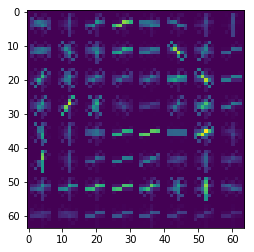

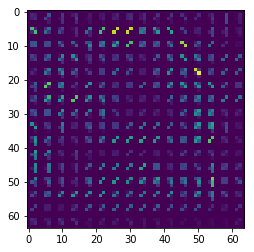

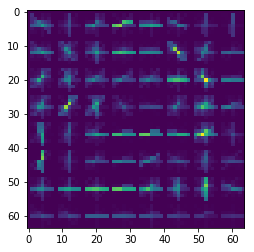

(1764,)
(8100,)
(3888,)


In [20]:
image = mpimg.imread(car_images[23])
spatial_img = cv2.resize(image[:,:,0],(32,32))
hog_hist = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 8, cell_per_block=2, vis=True)
hog_hist1 = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 4, cell_per_block=2, vis=True)
hog_hist2 = get_hog_features(image[:,:,0], orient = 12, pix_per_cell = 8, cell_per_block=6, vis=True)
hog_hist3 = get_hog_features(image[:,:,0], orient = 11, pix_per_cell = 16, cell_per_block=2, vis=True)
plt.imshow(hog_hist[1])
plt.show()
plt.imshow(hog_hist1[1])
plt.show()
plt.imshow(hog_hist2[1])
plt.show()
plt.imshow(hog_hist3[1])
plt.show()

print(hog_hist[0].shape)
print(hog_hist1[0].shape)
print(hog_hist2[0].shape)


## Feature Visualization

E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


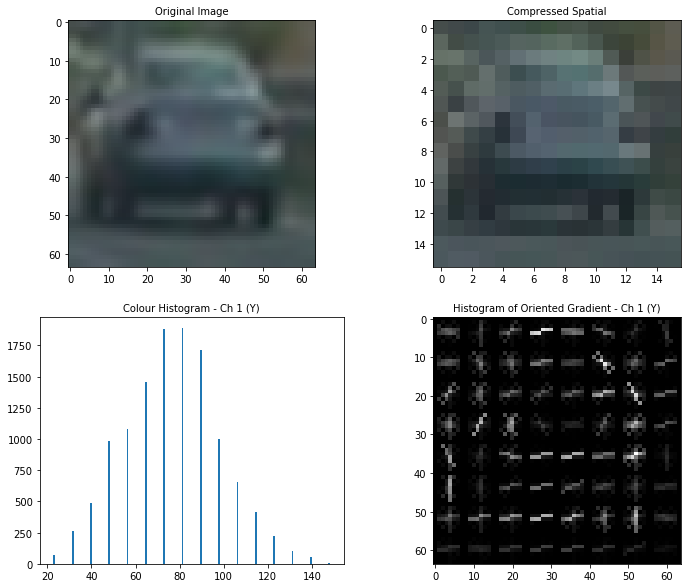

In [24]:
image = cv2.imread(car_images[23])
image1 = convert_color(image, conv='BGR2RGB')
spatial_img = cv2.resize(image,(16,16))
hog_hist = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 8, cell_per_block=2, vis=True)
color_hist,bins = np.histogram(image[:,:,], bins=16)

f,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(12,10), gridspec_kw={'hspace':0.2})

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=10)
spatial_img = convert_color(spatial_img, conv='BGR2RGB')
ax2.imshow(spatial_img)
ax2.set_title('Compressed Spatial', fontsize=10)
#hog_hist[1] = convert_color(hog_hist[1], conv='BGR2RGB')
ax4.imshow(hog_hist[1], cmap ='gray')
ax4.set_title('Histogram of Oriented Gradient - Ch 1 (Y)', fontsize=10)
center = (bins[:-1]+bins[1:])/2 #find point for each bin in bar graph to be centered around 
ax3.bar(center, color_hist)
ax3.set_title('Colour Histogram - Ch 1 (Y)', fontsize=10)

## Sliding Window on Test Image Visualization

In [26]:
test_images = glob.glob('saveframes/all/22/*.jpg')
rame = "test_images/test1/0/frame482.jpg"
write = "frame480.jpg"
i=8220

for frame in test_images:
    img = cv2.imread(str(frame))

    image_find = np.copy(img)
    out_img, bbox = find_cars(image_find, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox = np.asarray(bbox)
    #bbox_1 = (bbox[:,0,0]>810)&(bbox[:,0,1]>300)&(bbox[:,0,0]<955)&(bbox[:,0,1]<600)
    #bbox_arr = bbox[bbox_1]
    
    for sample in bbox:
        x1 = sample[0][0]
        y1 = sample[0][1]
        x2 = sample[1][0]
        y2 = sample[1][1]

        car_save = img[int(y1):int(y2),int(x1):int(x2),:]
        image = cv2.resize(car_save, (64,64))
        cv2.imwrite("white/22/%d.jpg" %i,image)
        #print("Success")
        i += 1


E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


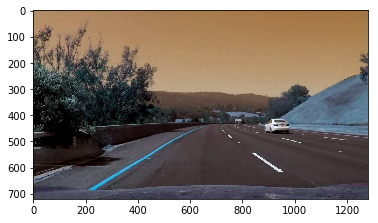

In [141]:
img = cv2.imread("test_images/test1/3/frame622.jpg")
plt.imshow(img)

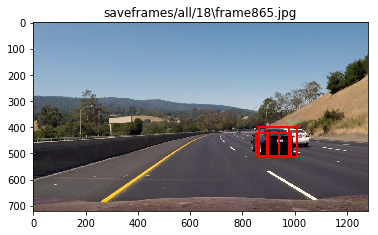

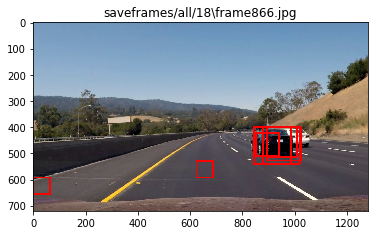

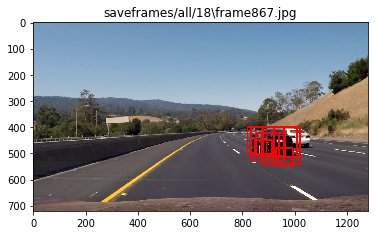

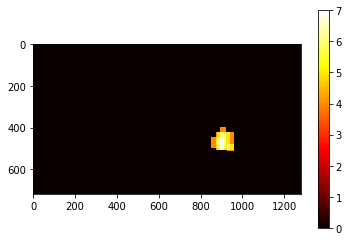

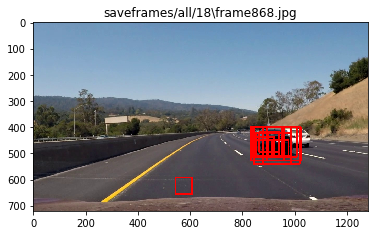

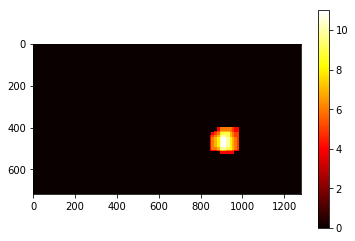

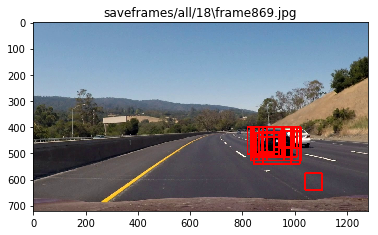

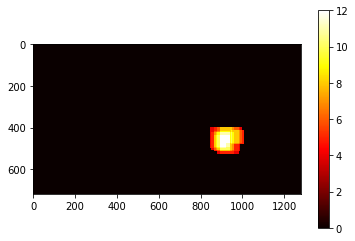

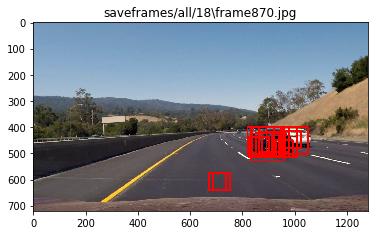

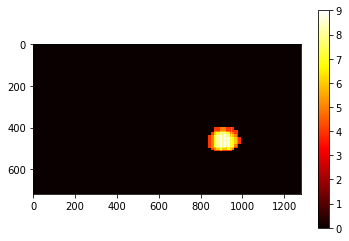

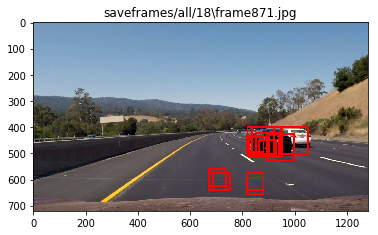

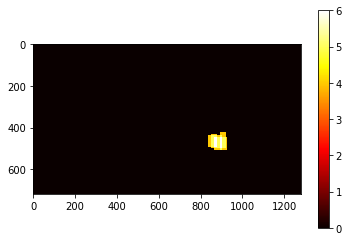

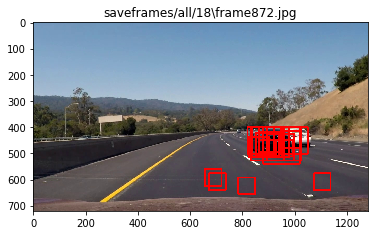

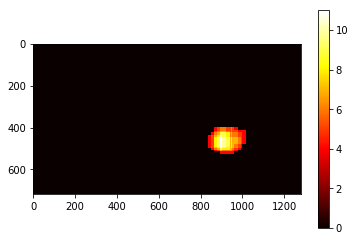

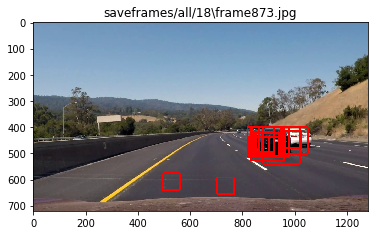

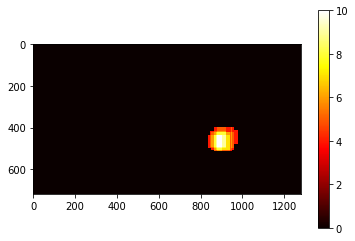

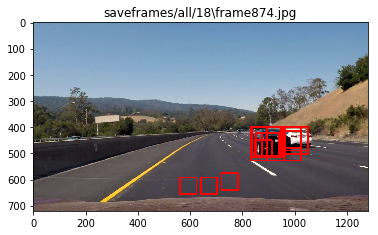

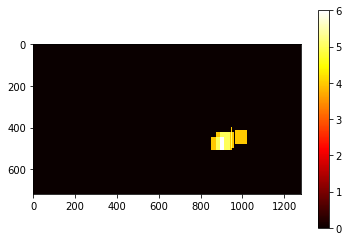

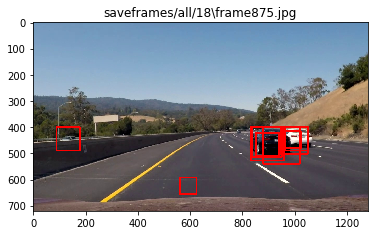

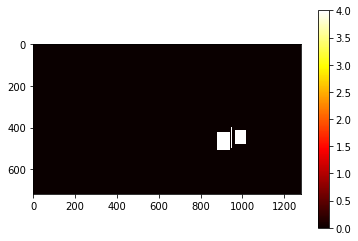

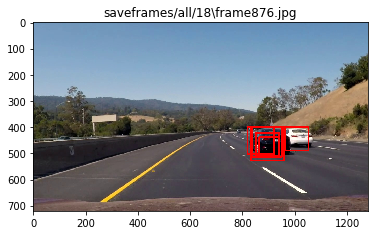

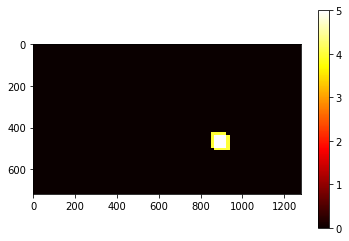

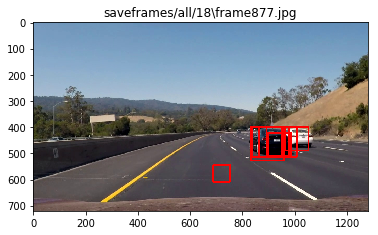

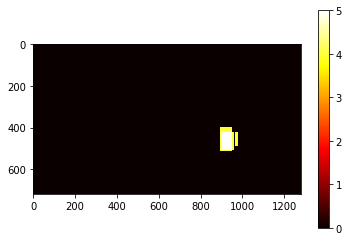

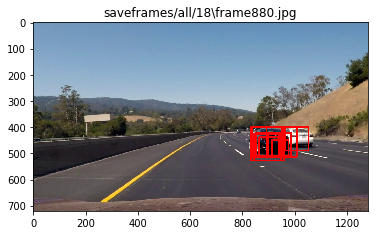

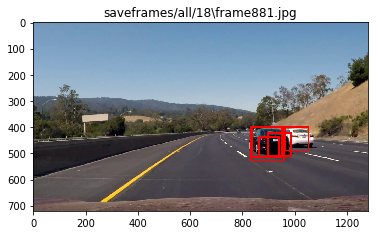

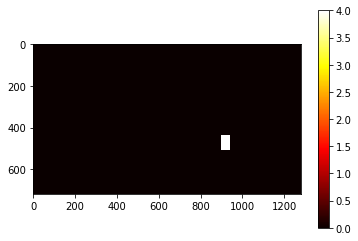

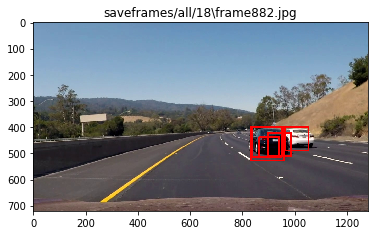

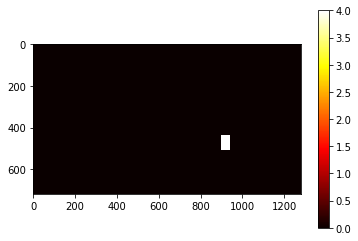

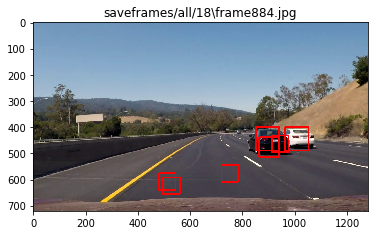

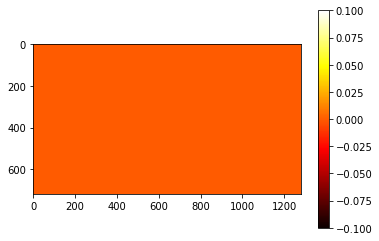

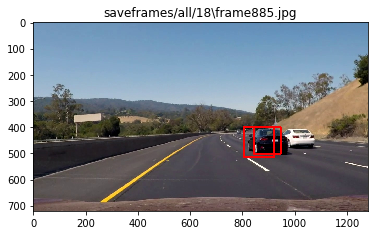

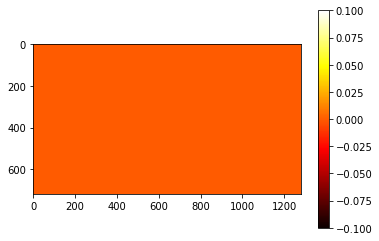

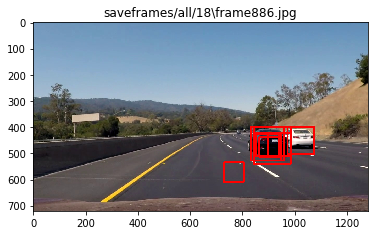

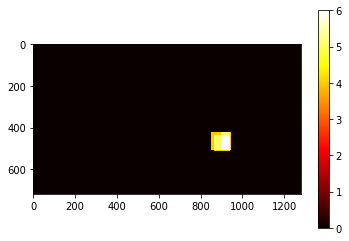

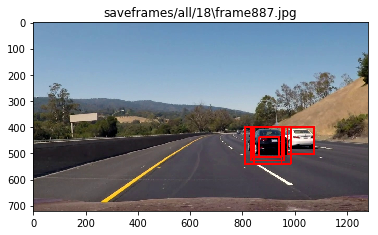

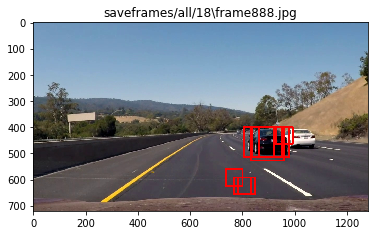

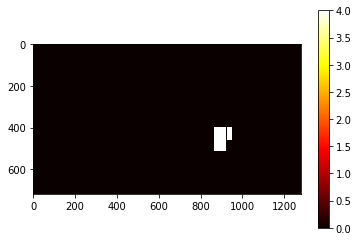

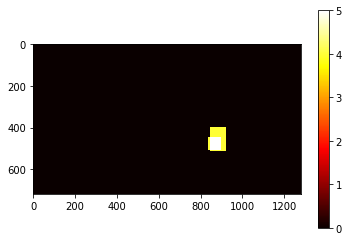

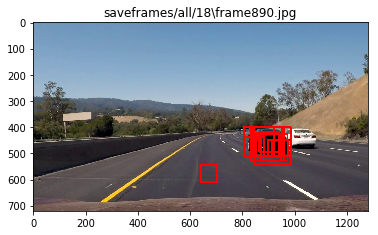

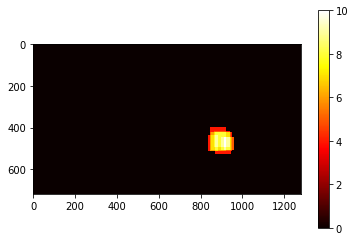

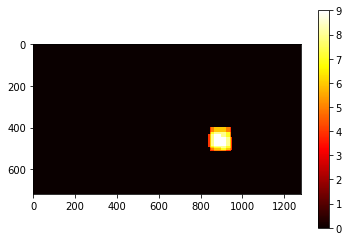

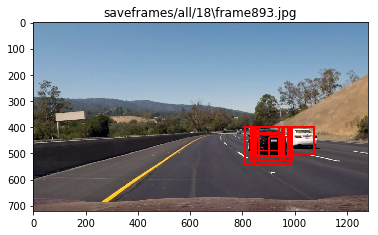

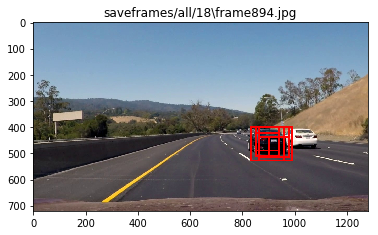

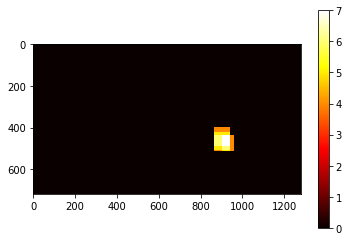

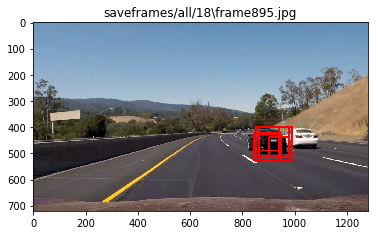

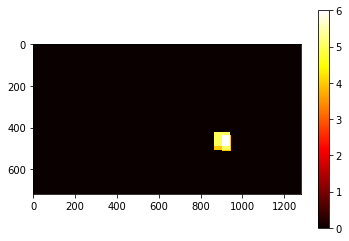

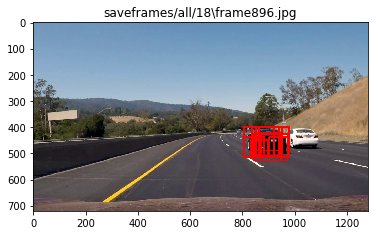

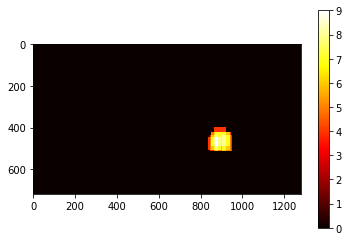

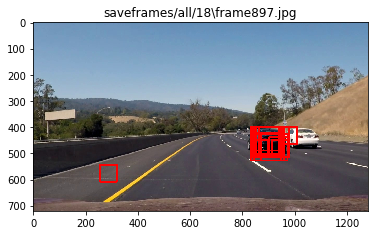

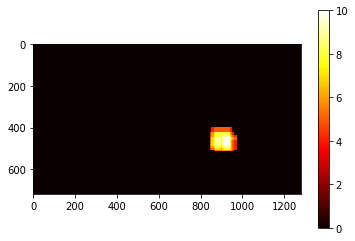

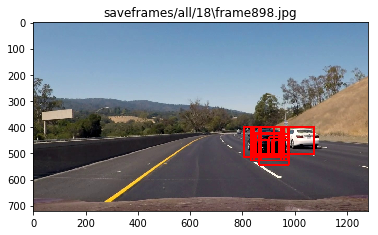

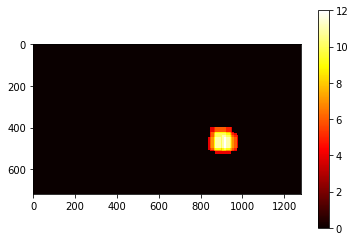

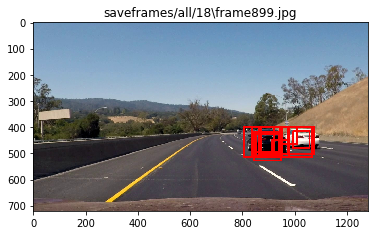

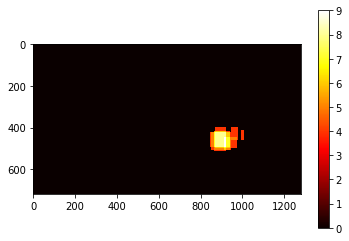

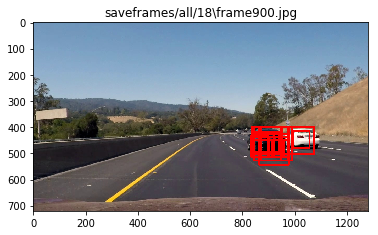

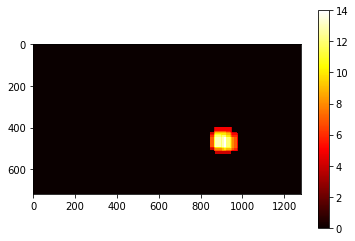

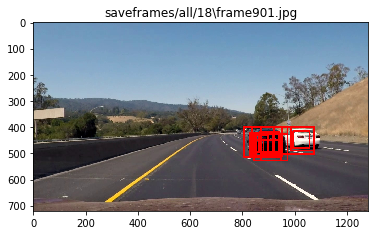

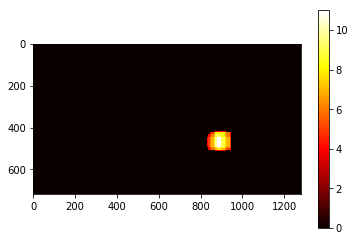

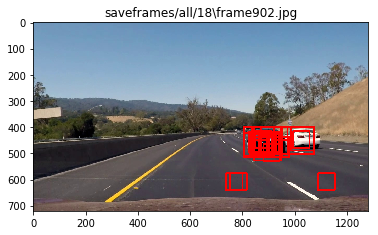

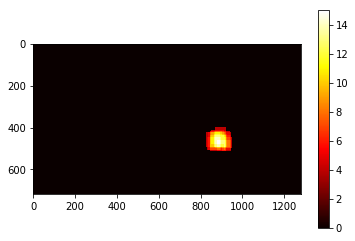

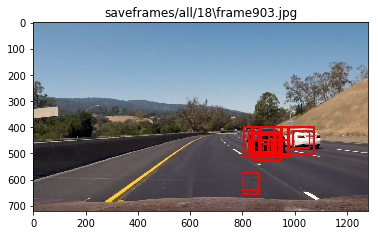

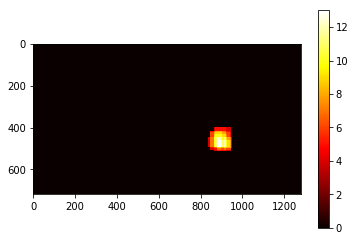

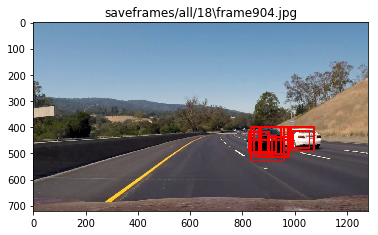

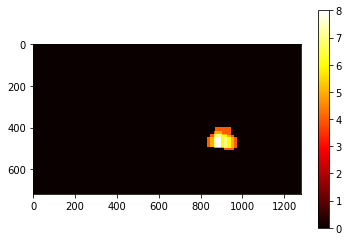

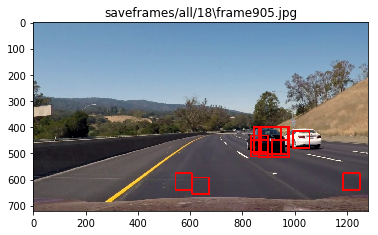

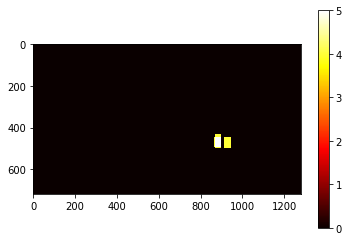

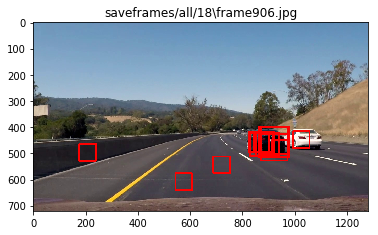

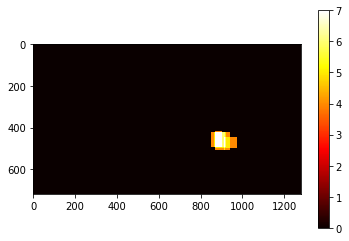

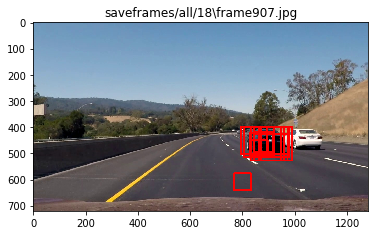

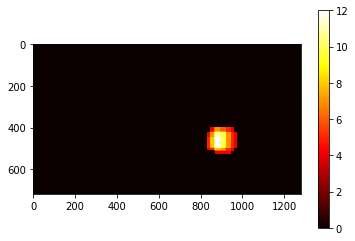

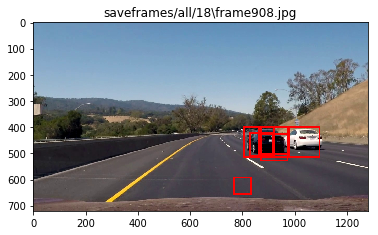

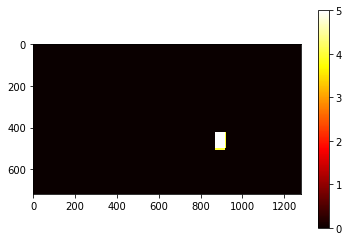

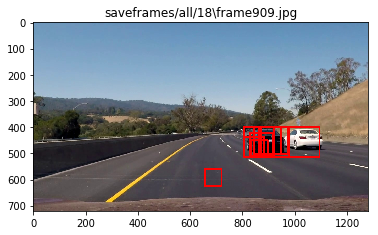

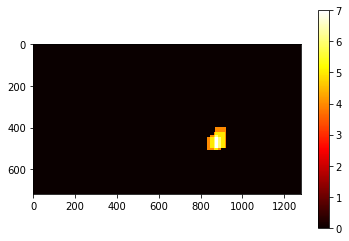

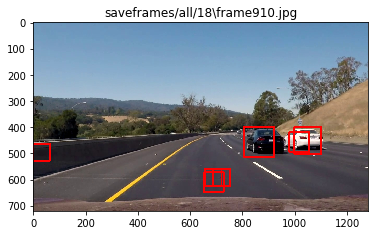

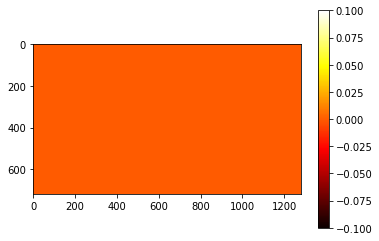

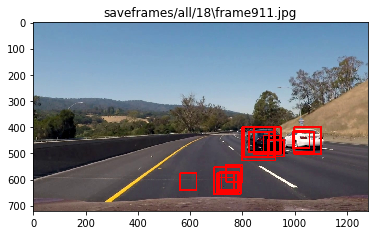

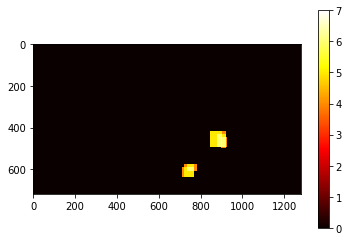

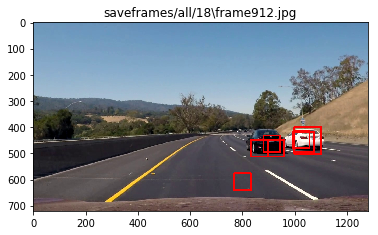

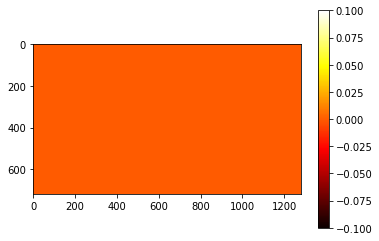

In [149]:
test_images = glob.glob('saveframes/all/18/*.jpg')
heat_map = Heat()
#f,([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(24, 16), gridspec_kw={'hspace':0.1})
#fig,ax = plt.subplots()
#fig = plt.figure(figsize=(12,300))
i=1
j=6063

for file in test_images:
    img = cv2.imread(str(file))
    image_find = np.copy(img)
    out_img, bbox = find_cars(image_find, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    ##bboxes = Gather(heat_map)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final = convert_color(out_img, conv='BGR2RGB')
    draw_img,bbox_single = draw_labeled_bboxes(img, labels)
    
    x1 = bbox_single[0][0]
    y1 = bbox_single[0][1]
    x2 = bbox_single[1][0]
    y2 = bbox_single[1][1]
    
    """
    if (x1!=0)&(y1!=0):
        car_save = img[int(y1):int(y2),int(x1):int(x2),:]
        image = cv2.resize(car_save, (64,64))
        cv2.imwrite("white/%d.jpg" %j,image)
        #print("Success")
        j += 1
    
    cv2.imwrite("output/%d.jpg" %j,draw_img)
    j+=1
    """
    fig,ax = plt.subplots()
    cax = ax.imshow(final)
    ax.set_title(str(file))
    
    
    fig,ax = plt.subplots()
    cax = ax.imshow(heatmap,cmap='hot')
    cbar = fig.colorbar(cax)
    
    plt.show()
    
    """
    ax = fig.add_subplot(61, 2, i)
    ax.imshow(final)
    ax.set_title(str(file))
    i += 1
    
    ax = fig.add_subplot(61, 2, i)
    ax.imshow(heatmap, cmap='hot')
    ax.set_title(str(file))
    i += 1
    """

    #f,([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(24, 16), gridspec_kw={'hspace':0.1})
    #ax1.imshow(out_img)
    #ax1.set_title('Window Search')
    #ax2.imshow(draw_img)
    #ax2.set_title('Car Positions')
    #ax3.imshow(heatmap, cmap='hot')
    #ax3.set_title('Heat Map')
    #f.delaxes(ax4)
    #plt.draw()

    

    

In [35]:
fig.savefig("output/26.jpg")

## Bounding Box Visualization

In [40]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars1(img, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.asarray(img)
    img_tosearch = draw_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    #ctrans_tosearch = img_tosearch
    
    bbox_list=[]
    
    for scale in np.arange(1.0,2.8,0.2):
        if scale != 1:
            imshape = img_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) + 1 # i.e. 2x2 blocks = 19 blocks
        nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
        nfeat_per_block = orient*cell_per_block**2 #squared for 2 dimensions: x and y

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) -  1 # 7 blocks per window
        cells_per_step_x = 2
        cells_per_step_y = 2 # Instead of overlap, define how many cells to step 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x #steps taken by window
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):

                ypos = yb*cells_per_step_y
                xpos = xb*cells_per_step_x
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                feature = np.asarray(subimg)

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(feature, nbins=hist_bins)
                
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
                test_prediction = load_model.predict(test_features)
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


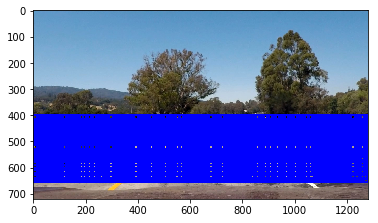

In [41]:
image = mpimg.imread("test_images/test1.jpg")
out_img, bbox = find_cars1(image, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

## Heat Map Visualization

In [ ]:
test_images = glob.glob('test_images/test1/0/*.jpg')
heat_map = Heat()
fig = plt.figure(figsize=(15,80))
i=1
hmap = collections.deque([],maxlen=6)
for file in test_images:
    img = cv2.imread(str(file))
    image_find = np.copy(img)
    out_img, bbox = find_cars(image_find, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    bboxes = Gather(heat_map)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,6)
    hmap.append(heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final = convert_color(out_img, conv='BGR2RGB')
    draw_img = draw_labeled_bboxes(img, labels)
    
    ax = fig.add_subplot(20, 2, i)
    ax.imshow(final)
    ax.set_title(str(file))
    i += 1
    ax = fig.add_subplot(20, 2, i)
    ax.imshow(heatmap, cmap='hot')
    ax.set_title(str(file))
    i += 1
#fig.savefig("examples/bboxes_and_heat1.png")
    

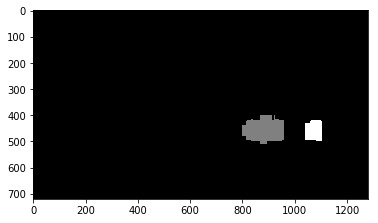

In [51]:
maps = np.asarray(hmap)
if len(maps)>0:
    avg=0
    for map in maps:
        avg +=map
    #avg = avg / len(maps)
else:
    avg = np.zeros_like(self[:,:,0]).astype(np.float)
heat123 = apply_threshold(avg,35)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat123, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.imshow(labels[0],cmap='gray')
#final = convert_color(out_img, conv='BGR2RGB')
#draw_img = draw_labeled_bboxes(img, labels)


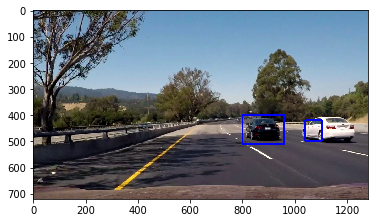

In [53]:
overlay = mpimg.imread('saveframes/frame979.jpg')
draw_img = draw_labeled_bboxes(overlay, labels)
plt.imshow(draw_img)